# Quality Assurance/Quality Control for pH Time Series

## Import `PLT.py` functions

In [1]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


```python
    def get_hydrocat(start_date, end_date, buoy):
        """
        Retrieve Hydrocat data from Andy Davies' sensors using the API
        Drop 0 or negative pH values
        Time zone kept in UTC
        Convert pH from NBS to total scale using PyCO2SYS
        
        INPUTS:
            - start_date: date as a string, formatted as YYYY-MM-DD
            - end_date: date as a string, formatted as YYYY-MM-DD
            - buoy: Jamestown/620/PLT or 720/Greenwich Bay/BG
        
        RETURNS pandas DataFrame
        
        Add '%cd directory' and '%run PLT.py' to your script, making sure the path is correct
        """
        return df
```

```python
        def dic_to_uM(dic, S, T):
        """
        This function converts from units of umol/kg to uM [umol/L] 
        by calculating density using an equation of state.
        
        INPUTS:
            - DIC or TA in umol/kg
            - Salinity in PSU
            - Temperature in degrees C
        
        OUTPUTS:
            - DIC or TA in uM
        
        """
        return dic_out
```

```python
def get_lab_samples(googlesheet_url, wks_name):
        
        """
        Retrieve lab data from Wang Lab Google folder using the API
        Convert data to appropriate data types
        Drop rows where TA, DIC, and/or salinity is not recorded
        Time zone converted to UTC
        Convert lab measured TA [uM] and DIC [uM] to TA [umol/kg] and DIC [umol/kg]...
            ...using gsw.rho(S,T,P)
        Calculate total pH using PyCO2SYS
        
        INPUTS:
            - URL of the Google sheet as a string
            - worksheet name as a string
        
        RETURNS pandas DataFrame with
            - Sample Name
            - Sample Location
            - DateTime in UTC
            - Sample Location
            - Sample depth
            - DIC [umol/kg]
            - TA [umol/kg]
            - Salinity
            - pH in total scale
        
        Add '%cd directory' and '%run PLT.py' to your script, making sure the path is correct
        """
        return dfout
```

```python
def get_NBFSMN(googlesheet_url, wks_name):
        
        """
        Retrieve NBFSMN data from Wang Lab Google folder using the API
        Convert data to appropriate data types
        Drop rows where TA, DIC, and/or DO is not recorded
        Drop columns with unnecessary data
        Convert NBS pH to total pH
        
        INPUTS:
            - URL of the Google sheet as a string
            - worksheet name as a string
        
        RETURNS pandas DataFrame with
            - Sample Date
            - DateTime in UTC
            - Surface Temperature [degC]
            - Surface Salinity
            - Surface DO concentration [mg/L]
            - pH in total scale
        
        Add '%cd directory' and '%run PLT.py' to your script, making sure the path is correct
        """
        return df
```

## Import packages

`conda env list`

`conda activate base`

`pip install ipywidgets`

`jupyter labextension install @jupyter-widgets/jupyterlab-manager`

In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Get data

1. Hydrocat 620 (`hydrocat620`): Davies buoy at Jamestown/PLT
2. Hydrocat 720 (`hydrocat720`): Davies buoy at Greenwich Bay/GB
3. MV (`MV`): Narr Bay Fixed Station Monitoring Network at Mt. View near PLT
4. QP (`QP`): Narr Bay Fixed Station Monitoring Network at Quonset Pt near GB
5. Lab data (`labdf`): TA [umol/kg], DIC [umol/kg], and pH from all lab samples (i.e. from both PLT and GB)
6. SeaFET sensor (`seafet`): Wang buoy near PLT, data held locally

In [3]:
hydrocat620 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'PLT')
hydrocat720 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'GB')
MV = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1fK_lYz7PiTGOt7UZanFDcQ0H8WAhbiujo3i07f4lnHE/edit#gid=813729054', 'MV')
QP = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw/edit#gid=2053781657','QP')
labdf = PLT.get_lab_samples('https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0.', 'Sheet1')

In [4]:
seafet = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/pH.csv')
seafet.drop(seafet.tail(6).index,inplace=True)
seafet = seafet.rename(columns={"DateTime (UTC-04:00)": "DateTime"})

# Test removal of outliers using interquartile range

I fear this method removes *too* many points.

In [15]:
def rmoutliers(dataframe, var):
    # IQR
    # Calculate the upper and lower limits
    Q1 = dataframe[var].quantile(0.25)
    Q3 = dataframe[var].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(dataframe[var]>=upper)[0]
    lower_array = np.where(dataframe[var]<=lower)[0]
    
    TT = dataframe.where(dataframe[var] <= upper).dropna()
    TT = TT.where(dataframe[var] >= lower).dropna()
    
    return TT

In [20]:
hydrocat620_new = rmoutliers(hydrocat620, 'pH total')

Text(0.5, 0, 'Year-Month')

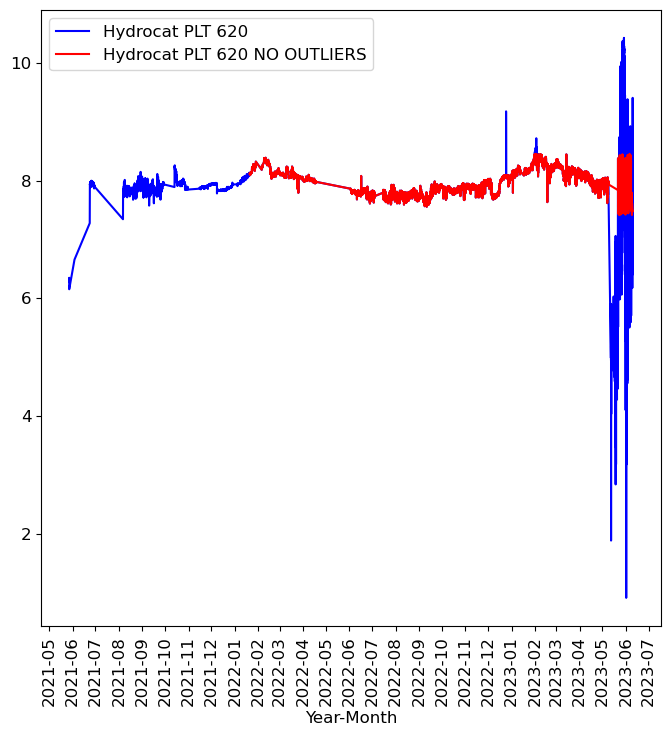

In [17]:
fig,ax = plt.subplots(figsize=[8,8])
ax.plot(hydrocat620['DateTime'], hydrocat620['pH total'], color = 'blue', label = 'Hydrocat PLT 620')
ax.plot(hydrocat620_new['DateTime'], hydrocat620_new['pH total'], color = 'red', label = 'Hydrocat PLT 620 NO OUTLIERS')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

# Test removal of outliers using standard deviations

This is the method the NBFSMN used to remove outliers.

In [8]:
def rmoutliers_STD(dataframe, var):
    # Calculate the upper and lower limits
    # As defined by 2 standard deviations more/less than mean
    STD = dataframe[var].std()
    MN = dataframe[var].mean()
    LOWER = MN - 2*STD
    UPPER = MN + 2*STD

    for ind in dataframe.index:
        if dataframe[var][ind] > UPPER:
            dataframe = dataframe.drop(ind)
        elif dataframe[var][ind] < LOWER:
            dataframe = dataframe.drop(ind)
    df = dataframe.reset_index(drop=True)
    
    return df

In [154]:
hydrocat620_STD = rmoutliers_STD(hydrocat620, 'pH total')

Text(0.5, 0, 'Year-Month')

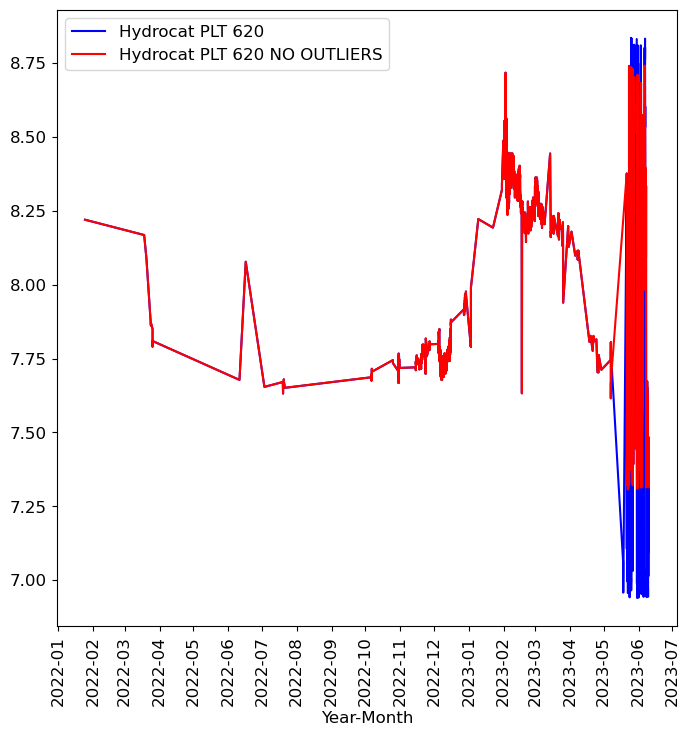

In [106]:
fig,ax = plt.subplots(figsize=[8,8])
ax.plot(hydrocat620['DateTime'], hydrocat620['pH total'], color = 'blue', label = 'Hydrocat PLT 620')
ax.plot(hydrocat620_STD['DateTime'], hydrocat620_STD['pH total'], color = 'red', label = 'Hydrocat PLT 620 NO OUTLIERS')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)

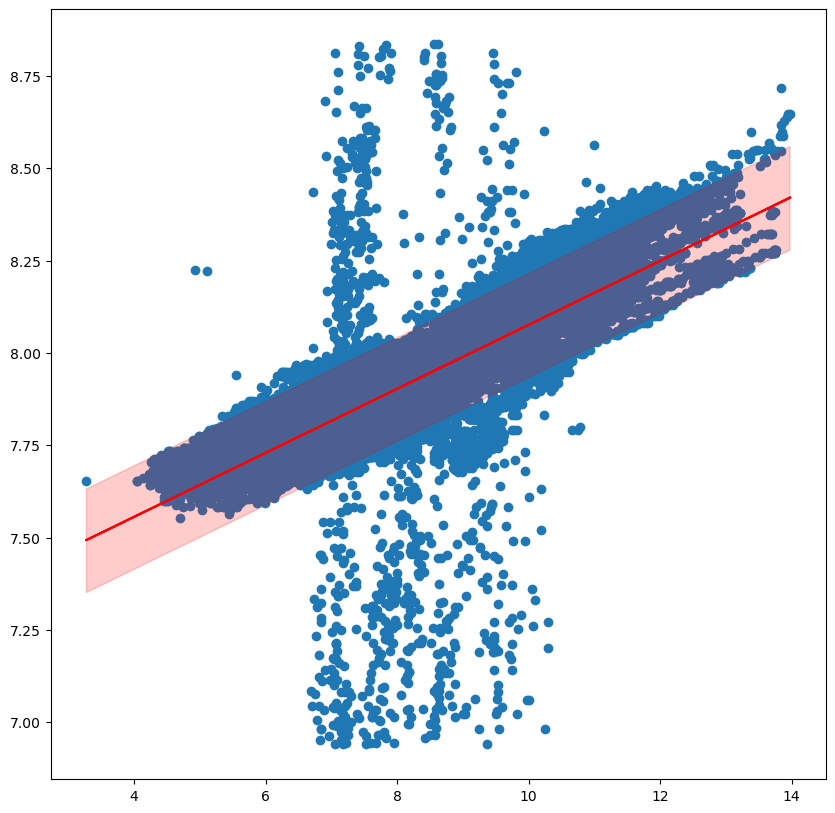

In [155]:
# LinearRegression requires reshaping of the data so this converts the pandas series to 
# a numpy array and then reshapes
x = hydrocat620_STD['hydrocatDissOxygen'].to_numpy().reshape(-1, 1)
y = hydrocat620_STD['pH total'].to_numpy().reshape(-1, 1)
model = LinearRegression().fit(x, y)
delt = mean_absolute_error(y, y_pred)

# this line predicts y (i.e. pH) based on the input x (i.e. dissolved oxygen)
# in other words, these are the y values of the linear model
y_pred = model.predict(x)

# added the predicted pH to the dataset
hydrocat620_STD['pH_pred'] = y_pred
# added the difference between the predicted pH and the actual pH
hydrocat620_STD['pH - pH_pred'] = y - y_pred
# selecting the part of the dataset where the diff between predicted and actual is greater than 2 stds
hydrocat620_STD.where(np.abs(hydrocat620_STD['pH - pH_pred']) > 2*delt).dropna()

fig, ax = plt.subplots(figsize = [10,10])

# plot x: x = surfaceMV['surface DO Conc'].to_numpy().reshape(-1, 1)
# by y  : y = surfaceMV['pH total'].to_numpy().reshape(-1, 1)
ax.scatter(x,y)
# x by the predicted y
ax.plot(x,y_pred, color = 'red')
# add eerror lines
# ax.plot(x,y_pred - 2*delt, color = 'red')
# ax.plot(x,y_pred + 2*delt, color = 'red')
mockX = np.arange(hydrocat620_STD['hydrocatDissOxygen'].min(), hydrocat620_STD['hydrocatDissOxygen'].max(), 0.1).reshape(-1, 1)
mockY = model.predict(mockX)
ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] + 2*delt, color = 'r', alpha = 0.2)
ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - 2*delt, color = 'r', alpha = 0.2)


# Interactive quality control

When run, the function prompts you to select the dataset you are interested in, your X variable, your Y variable, the size of your error bar (in number of standard errors), and whether you would like to remove the outliers that are beyond your error bars.

It works as follows:

1. Retrieve the selected dataset using functions defined in `PLT.py`
2. First removal of outliers by eliminating any pH values that are in excess of 2 standard deviations of the mean pH.
3. Identify corresponding data keys for X and Y variables
4. Linear regression between X and Y variable selections
5. Calculate standard error using `sklearn.metrics.mean_absolute_error(y, y_pred)`
6. Plot the correlation of X and Y with error bars. The size of the error bars is determined by the float slider, which determines the number of mean absolute errors from the mean on either side.
7. When "remove" is clicked, the function removes any points in the correlation outside of the error bars. 

To use:
1. Call `QAQC.widget`
2. Click "Run Interact"
3. Wait a minute, since the function takes a moment to run
4. The function will continue to rerun every time you click "Run Interact"
5. Removal of outliers is **global**, meaning if you choose to remove outliers from Hydrocat 620, subsequent calls of `hydrocat620` will have had outliers removed by this method.

In [9]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.metrics import mean_absolute_error
from IPython.display import display, Markdown, Latex


# @interact_manual
def qualitycontrol(dataset=widgets.RadioButtons(options=['Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'], description='Data', disabled = False),
                            X= widgets.RadioButtons(options=['Temperature','Oxygen', 'Salinity', 'DateTime','pH'], description='X Var:', disabled=False),
                            Y = widgets.RadioButtons(options=['Temperature','Oxygen', 'Salinity', 'DateTime','pH'], description='Y Var:', disabled=False),
                            E = widgets.FloatSlider(value=2,min=0,max=4,step=0.1,description='Error bar size:',disabled=False,
                                                    continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f'),
                            remove = widgets.Checkbox(value=False, description='Remove Outliers?', disabled=False, indent=False)):

    if dataset == 'Hydrocat 620':
        global hydrocat620
        hydrocat620 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'PLT')
        df = hydrocat620
        df = rmoutliers_STD(df, 'pH total')
        if X == 'Temperature':
            x = df['hydrocatTemperature']
        elif X == 'Oxygen':
            x = df['hydrocatDissOxygen']
        elif X == 'Salinity':
            x = df['hydrocatSalinity']
        elif X == 'DateTime':
            x = df['DateTime']
        elif X == 'pH':
            x = df['pH total']
        else:
            x = df['pH total']
        if Y == 'Temperature':
            y = df['hydrocatTemperature']
        elif Y == 'Oxygen':
            y = df['hydrocatDissOxygen']
        elif Y == 'Salinity':
            y = df['hydrocatSalinity']
        elif Y == 'DateTime':
            y = df['DateTime']
        elif Y == 'pH':
            y = df['pH total']
        else:
            y = df['pH total']
    elif dataset == 'Hydrocat 720':
        global hydrocat720
        hydrocat720 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'GB')
        df = hydrocat720
        df = rmoutliers_STD(df, 'pH total')
        if X == 'Temperature':
            x = df['hydrocatTemperature']
        elif X == 'Oxygen':
            x = df['hydrocatDissOxygen']
        elif X == 'Salinity':
            x = df['hydrocatSalinity']
        elif X == 'DateTime':
            x = df['DateTime']
        elif X == 'pH':
            x = df['pH total']
        else:
            x = df['pH total']
        if Y == 'Temperature':
            y = df['hydrocatTemperature']
        elif Y == 'Oxygen':
            y = df['hydrocatDissOxygen']
        elif Y == 'Salinity':
            y = df['hydrocatSalinity']
        elif Y == 'DateTime':
            y = df['DateTime']
        elif Y == 'pH':
            y = df['pH total']
        else:
            y = df['pH total']
    elif dataset == 'MV':
        global MV
        MV = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1fK_lYz7PiTGOt7UZanFDcQ0H8WAhbiujo3i07f4lnHE/edit#gid=813729054', 'MV')
        df = MV
        df = rmoutliers_STD(df, 'pH total')
        if X == 'Temperature':
            x = df['surface Temp']
        elif X == 'Oxygen':
            x = df['surface DO Conc']
        elif X == 'Salinity':
            x = df['surface Salinity']
        elif X == 'DateTime':
            x = df['DateTime']
        elif X == 'pH':
            x = df['pH total']
        else:
            x = df['pH total']
        if Y == 'Temperature':
            y = df['surface Temp']
        elif Y == 'Oxygen':
            y = df['surface DO Conc']
        elif Y == 'Salinity':
            y = df['surface Salinity']
        elif Y == 'DateTime':
            y = df['DateTime']
        elif Y == 'pH':
            y = df['pH total']
        else:
            y = df['pH total']
    elif dataset == 'QP':
        global QP
        QP = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw/edit#gid=2053781657','QP')
        df = QP
        df = rmoutliers_STD(df, 'pH total')
        if X == 'Temperature':
            x = df['surface Temp']
        elif X == 'Oxygen':
            x = df['surface DO Conc']
        elif X == 'Salinity':
            x = df['surface Salinity']
        elif X == 'DateTime':
            x = df['DateTime']
        elif X == 'pH':
            x = df['pH total']
        else:
            x = df['pH total']
        if Y == 'Temperature':
            y = df['surface Temp']
        elif Y == 'Oxygen':
            y = df['surface DO Conc']
        elif Y == 'Salinity':
            y = df['surface Salinity']
        elif Y == 'DateTime':
            y = df['DateTime']
        elif Y == 'pH':
            y = df['pH total']
        else:
            y = df['pH total']
    else:
        QP = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw/edit#gid=2053781657','QP')
        df = QP
        df = rmoutliers_STD(df, 'pH total')
        if X == 'Temperature':
            x = df['surface Temp']
        elif X == 'Oxygen':
            x = df['surface DO Conc']
        elif X == 'Salinity':
            x = df['surface Salinity']
        elif X == 'DateTime':
            x = df['DateTime']
        elif X == 'pH':
            x = df['pH total']
        else:
            x = df['pH total']
        if Y == 'Temperature':
            y = df['surface Temp']
        elif Y == 'Oxygen':
            y = df['surface DO Conc']
        elif Y == 'Salinity':
            y = df['surface Salinity']
        elif Y == 'DateTime':
            y = df['DateTime']
        elif Y == 'pH':
            y = df['pH total']
        else:
            y = df['pH total']
    
    xx = x.to_numpy().reshape(-1, 1)
    yy = y.to_numpy().reshape(-1, 1)
    model = LinearRegression().fit(xx, yy)
    y_pred = model.predict(xx)
    df[Y+'_pred'] = y_pred
    df[Y + '-' + Y +'_pred'] = yy - y_pred
#     
    delt = mean_absolute_error(yy, y_pred)
    
    fig, ax = plt.subplots(figsize = [10,10])
    ax.scatter(xx,yy)
    ax.plot(xx,y_pred, color = 'red')
    
    mockX = np.arange(x.min(), x.max(), 0.1).reshape(-1, 1)
    mockY = model.predict(mockX)
    ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] + E*delt, color = 'r', alpha = 0.2)
    ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)
    
    ax.set_title(dataset)
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    fig.show()
    df2 = df
    
    
    if remove == True:
        df2 = df2.where(np.abs(df2[Y + '-' + Y +'_pred']) < E*delt).dropna()
        df2 = df2.reset_index(drop=True)
        if dataset == 'Hydrocat 620':
            df2 = df2.where(df2['DateTime'] < pd.Timestamp(datetime(2023, 5, 7, 0, 0,0))).dropna()
            df2 = df2.reset_index(drop=True)
            hydrocat620 = df2
            print('Outliers removed from Hydrocat 620. The output dataset is called `hydrocat620`.')
        elif dataset == 'Hydrocat 720':
            hydrocat720 = df2
            display(Markdown('# Outliers removed from Hydrocat 720. The output dataset is called `hydrocat720`.'))
        elif dataset == 'MV':
            MV = df2
            print('Outliers removed from MV. The output dataset is called `MV`.')
        elif dataset == 'QP':
            QP = df2
            print('Outliers removed from QP. The output dataset is called `QP`.')
    else:
        return
    

      
QAQC = interact_manual(qualitycontrol)




interactive(children=(RadioButtons(description='Data', options=('Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'), v…

In [10]:
interact_manual(qualitycontrol)

interactive(children=(RadioButtons(description='Data', options=('Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'), v…

<function __main__.qualitycontrol(dataset=RadioButtons(description='Data', options=('Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'), value='Hydrocat 620'), X=RadioButtons(description='X Var:', index=1, options=('Temperature', 'Oxygen', 'Salinity', 'DateTime', 'pH'), value='Oxygen'), Y=RadioButtons(description='Y Var:', index=4, options=('Temperature', 'Oxygen', 'Salinity', 'DateTime', 'pH'), value='pH'), E=FloatSlider(value=2.0, continuous_update=False, description='Error bar size:', max=4.0, readout_format='.1f'), remove=Checkbox(value=True, description='Remove Outliers?', indent=False))>

In [7]:
interact_manual(qualitycontrol)

interactive(children=(RadioButtons(description='Data', index=1, options=('Hydrocat 620', 'Hydrocat 720', 'MV',…

<function __main__.qualitycontrol(dataset=RadioButtons(description='Data', index=1, options=('Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'), value='Hydrocat 720'), X=RadioButtons(description='X Var:', index=1, options=('Temperature', 'Oxygen', 'Salinity', 'DateTime', 'pH'), value='Oxygen'), Y=RadioButtons(description='Y Var:', index=4, options=('Temperature', 'Oxygen', 'Salinity', 'DateTime', 'pH'), value='pH'), E=FloatSlider(value=2.0, continuous_update=False, description='Error bar size:', max=4.0, readout_format='.1f'), remove=Checkbox(value=True, description='Remove Outliers?', indent=False))>

# Prepare to merge datasets by time

- convert datetime to timestamp

- add ordinal time

In [11]:
hydrocat620["time"] = pd.to_datetime(hydrocat620['DateTime'])
hydrocat720["time"] = pd.to_datetime(hydrocat720['DateTime'])
MV["time"] = pd.to_datetime(MV['DateTime'])
QP["time"] = pd.to_datetime(QP['DateTime'])

In [12]:
labdf = PLT.get_lab_samples('https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0.', 'Sheet1')

In [13]:
labdf["time"] = pd.to_datetime(labdf['DateTime'])

In [14]:
hydrocat620['ordinal_time'] = np.zeros(len(hydrocat620['time']))
hydrocat720['ordinal_time'] = np.zeros(len(hydrocat720['time']))
MV['ordinal_time'] = np.zeros(len(MV['time']))
QP['ordinal_time'] = np.zeros(len(QP['time']))
labdf['ordinal_time'] = np.zeros(len(labdf['time']))
for i in hydrocat620.index:
    hydrocat620['ordinal_time'][i] = hydrocat620['time'][i].toordinal()
for j in hydrocat720.index:
    hydrocat720['ordinal_time'][j] = hydrocat720['time'][j].toordinal()
for k in MV.index:
    MV['ordinal_time'][k] = MV['time'][k].toordinal()
for l in QP.index:
    QP['ordinal_time'][l] = QP['time'][l].toordinal()
for m in labdf.index:
    labdf['ordinal_time'][m] = labdf['time'][m].toordinal()

In [15]:
labGB = labdf.where(labdf['Location']== 'GB').dropna()
labPLT = labdf.where(labdf['Location']== 'PLT').dropna()
labGB = labGB.reset_index(drop=True)
labPLT = labPLT.reset_index(drop=True)

In [16]:
labPLT.keys()

Index(['Sample', 'DateTime', 'Location', 'depth', 'Salinity', 'DIC (umol/kg)',
       'TA (umol/kg)', 'pH', 'time', 'ordinal_time'],
      dtype='object')

In [17]:
hydrocat620 = hydrocat620[['DateTime', 'time', 'ordinal_time', 'hydrocatTemperature', 'hydrocatDissOxygen', 'hydrocatSalinity', 'pH total']]
hydrocat720 = hydrocat720[['DateTime', 'time', 'ordinal_time', 'hydrocatTemperature', 'hydrocatDissOxygen', 'hydrocatSalinity', 'pH total']]
MV = MV[['DateTime', 'time', 'ordinal_time','surface Temp', 'surface Salinity', 'surface DO Conc', 'pH total']]
QP = QP[['DateTime', 'time', 'ordinal_time','surface Temp', 'surface Salinity', 'surface DO Conc', 'pH total']]

# Merge datasets by time

In [18]:
PLT_hydro620 = pd.merge_asof(labPLT, hydrocat620, on="time",tolerance = pd.Timedelta("45m"))

In [19]:
PLT_hydro620.head()

,Sample,DateTime_x,Location,depth,Salinity,DIC (umol/kg),TA (umol/kg),pH,time,ordinal_time_x,DateTime_y,ordinal_time_y,hydrocatTemperature,hydrocatDissOxygen,hydrocatSalinity,pH total
0,PLT 4/28/22 A,2022-04-28 11:30:00,PLT,surface,29.48,1893.800902,2037.524946,7.872124,2022-04-28 11:30:00,738273.0,NaN,NaN,NaN,NaN,NaN,NaN
1,PLT 4/28/22 B,2022-04-28 11:30:00,PLT,surface,29.48,1893.793216,2037.118191,7.871104,2022-04-28 11:30:00,738273.0,NaN,NaN,NaN,NaN,NaN,NaN
2,PLT 5/9/22 surf A,2022-05-09 11:30:00,PLT,surface,29.42,1946.599760,2034.019064,7.708114,2022-05-09 11:30:00,738284.0,NaN,NaN,NaN,NaN,NaN,NaN
3,PLT 5/9/22 surf B,2022-05-09 11:30:00,PLT,surface,29.42,1917.494827,2035.302901,7.800762,2022-05-09 11:30:00,738284.0,NaN,NaN,NaN,NaN,NaN,NaN
4,PLT 5/22/22 bottom,2022-05-22 11:30:00,PLT,bottom,30.62,1938.168218,2094.161828,7.881845,2022-05-22 11:30:00,738297.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
GB_hydro720 = pd.merge_asof(labGB, hydrocat720, on="time",tolerance = pd.Timedelta("30m"))
GB_hydro720.head()

,Sample,DateTime_x,Location,depth,Salinity,DIC (umol/kg),TA (umol/kg),pH,time,ordinal_time_x,DateTime_y,ordinal_time_y,hydrocatTemperature,hydrocatDissOxygen,hydrocatSalinity,pH total
0,GB B 9/9/22,2022-09-09 15:30:00,GB,surface,29.08,1846.899933,1919.731461,7.665826,2022-09-09 15:30:00,738407.0,2022-09-09 15:16:28.800000,738407.0,22.4851,4.801,28.1409,7.551555
1,GB A 9/9/22,2022-09-09 15:30:00,GB,surface,29.02,1846.784657,1917.825258,7.660493,2022-09-09 15:30:00,738407.0,2022-09-09 15:16:28.800000,738407.0,22.4851,4.801,28.1409,7.551555
2,GB B 9/20/22,2022-09-20 15:30:00,GB,surface,30.11,1900.005195,2010.119504,7.764747,2022-09-20 15:30:00,738418.0,2022-09-20 15:16:29,738418.0,21.8375,5.980,29.5931,7.684197
3,GB A 9/20/22,2022-09-20 15:30:00,GB,surface,30.09,1898.660774,2010.472258,7.770016,2022-09-20 15:30:00,738418.0,2022-09-20 15:16:29,738418.0,21.8375,5.980,29.5931,7.684197
4,GB A 10/25/22,2022-10-25 15:30:00,GB,surface,29.41,1893.418498,2006.880539,7.803939,2022-10-25 15:30:00,738453.0,2022-10-25 15:16:18.800000,738453.0,15.9951,6.773,28.0622,7.683279


In [21]:
GB_MV = pd.merge_asof(labGB, MV, on="time",tolerance = pd.Timedelta("30m"))
GB_MV.head()

,Sample,DateTime_x,Location,depth,Salinity,DIC (umol/kg),TA (umol/kg),pH,time,ordinal_time_x,DateTime_y,ordinal_time_y,surface Temp,surface Salinity,surface DO Conc,pH total
0,GB B 9/9/22,2022-09-09 15:30:00,GB,surface,29.08,1846.899933,1919.731461,7.665826,2022-09-09 15:30:00,738407.0,2022-09-09 15:30:00,738407.0,22.730,29.17,6.70,7.622075
1,GB A 9/9/22,2022-09-09 15:30:00,GB,surface,29.02,1846.784657,1917.825258,7.660493,2022-09-09 15:30:00,738407.0,2022-09-09 15:30:00,738407.0,22.730,29.17,6.70,7.622075
2,GB B 9/20/22,2022-09-20 15:30:00,GB,surface,30.11,1900.005195,2010.119504,7.764747,2022-09-20 15:30:00,738418.0,2022-09-20 15:30:00,738418.0,22.077,30.55,8.23,7.754706
3,GB A 9/20/22,2022-09-20 15:30:00,GB,surface,30.09,1898.660774,2010.472258,7.770016,2022-09-20 15:30:00,738418.0,2022-09-20 15:30:00,738418.0,22.077,30.55,8.23,7.754706
4,GB A 10/25/22,2022-10-25 15:30:00,GB,surface,29.41,1893.418498,2006.880539,7.803939,2022-10-25 15:30:00,738453.0,2022-10-25 15:30:00,738453.0,15.921,28.92,7.76,7.854489


In [22]:
PLT_QP = pd.merge_asof(labPLT, QP, on="time",tolerance = pd.Timedelta("30m"))
PLT_QP.head()

,Sample,DateTime_x,Location,depth,Salinity,DIC (umol/kg),TA (umol/kg),pH,time,ordinal_time_x,DateTime_y,ordinal_time_y,surface Temp,surface Salinity,surface DO Conc,pH total
0,PLT 4/28/22 A,2022-04-28 11:30:00,PLT,surface,29.48,1893.800902,2037.524946,7.872124,2022-04-28 11:30:00,738273.0,NaT,NaN,NaN,NaN,NaN,NaN
1,PLT 4/28/22 B,2022-04-28 11:30:00,PLT,surface,29.48,1893.793216,2037.118191,7.871104,2022-04-28 11:30:00,738273.0,NaT,NaN,NaN,NaN,NaN,NaN
2,PLT 5/9/22 surf A,2022-05-09 11:30:00,PLT,surface,29.42,1946.599760,2034.019064,7.708114,2022-05-09 11:30:00,738284.0,NaT,NaN,NaN,NaN,NaN,NaN
3,PLT 5/9/22 surf B,2022-05-09 11:30:00,PLT,surface,29.42,1917.494827,2035.302901,7.800762,2022-05-09 11:30:00,738284.0,NaT,NaN,NaN,NaN,NaN,NaN
4,PLT 5/22/22 bottom,2022-05-22 11:30:00,PLT,bottom,30.62,1938.168218,2094.161828,7.881845,2022-05-22 11:30:00,738297.0,NaT,NaN,NaN,NaN,NaN,NaN


# Difference between sensor pH and lab pH

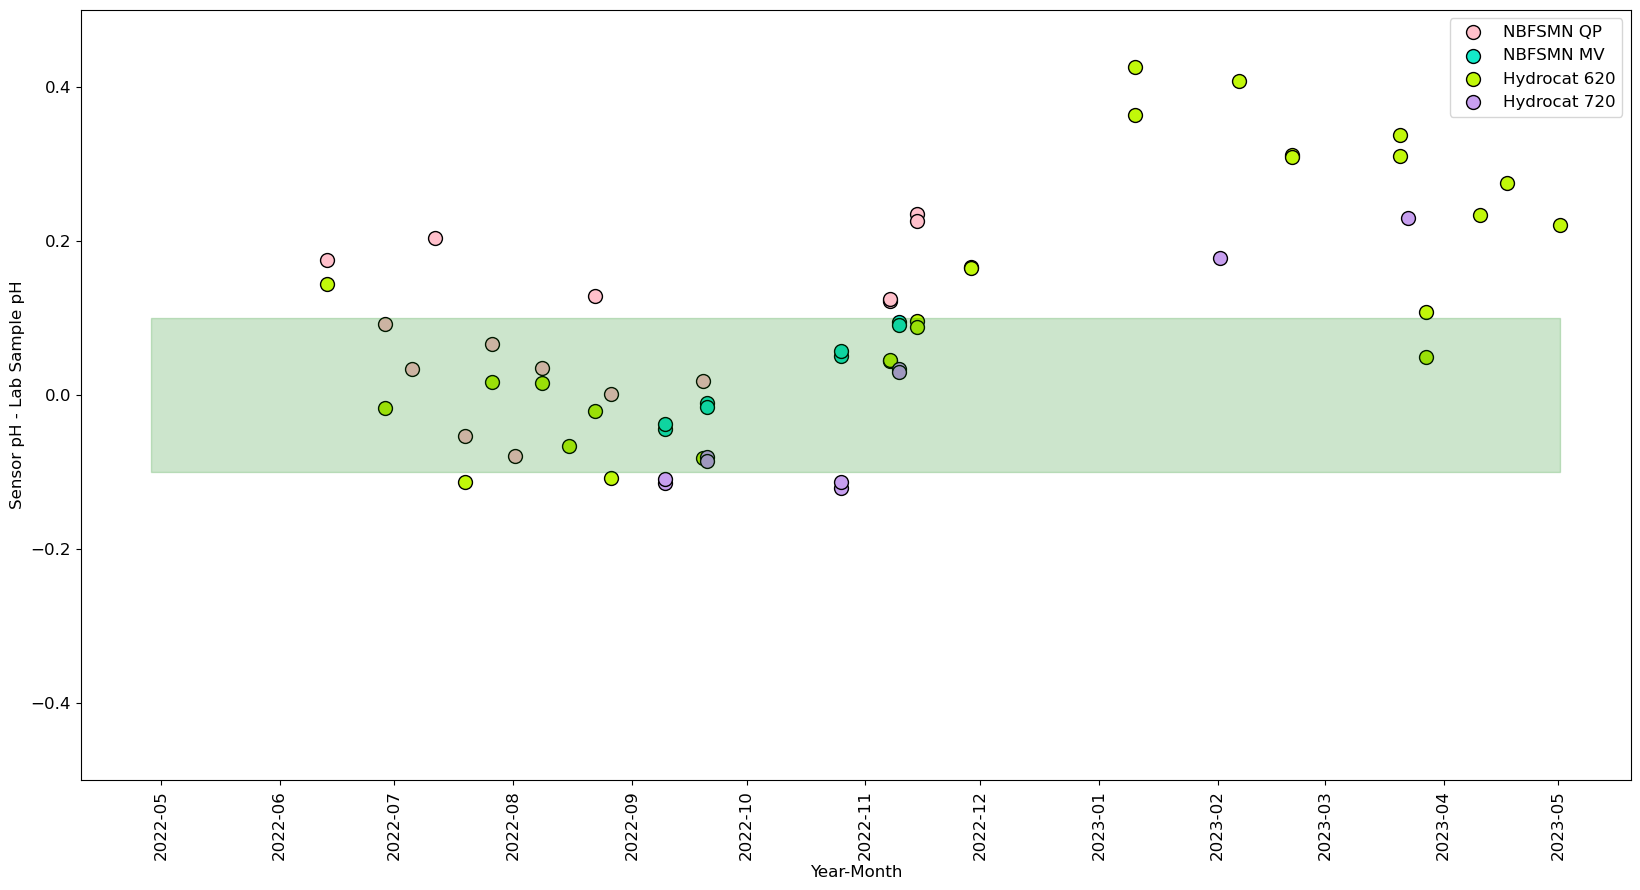

In [23]:
fig, ax = plt.subplots(figsize = [20,10])

ax.scatter(PLT_QP['time'],PLT_QP['pH total'] - PLT_QP['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
ax.scatter(GB_MV['time'],GB_MV['pH total'] - GB_MV['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#13EAC9', label = 'NBFSMN MV')
ax.scatter(PLT_hydro620['time'],PLT_hydro620['pH total'] - PLT_hydro620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')
ax.scatter(GB_hydro720['time'],GB_hydro720['pH total'] - GB_hydro720['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#C79FEF', label = 'Hydrocat 720')

ax.fill_between(PLT_hydro620['time'], -0.1, 0.1, color = 'g', alpha = 0.2)
# ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax.set_ylim([-0.5,0.5])

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/lab_minus_davies_anoms.png', bbox_inches='tight')


# A few perspectives on the time series

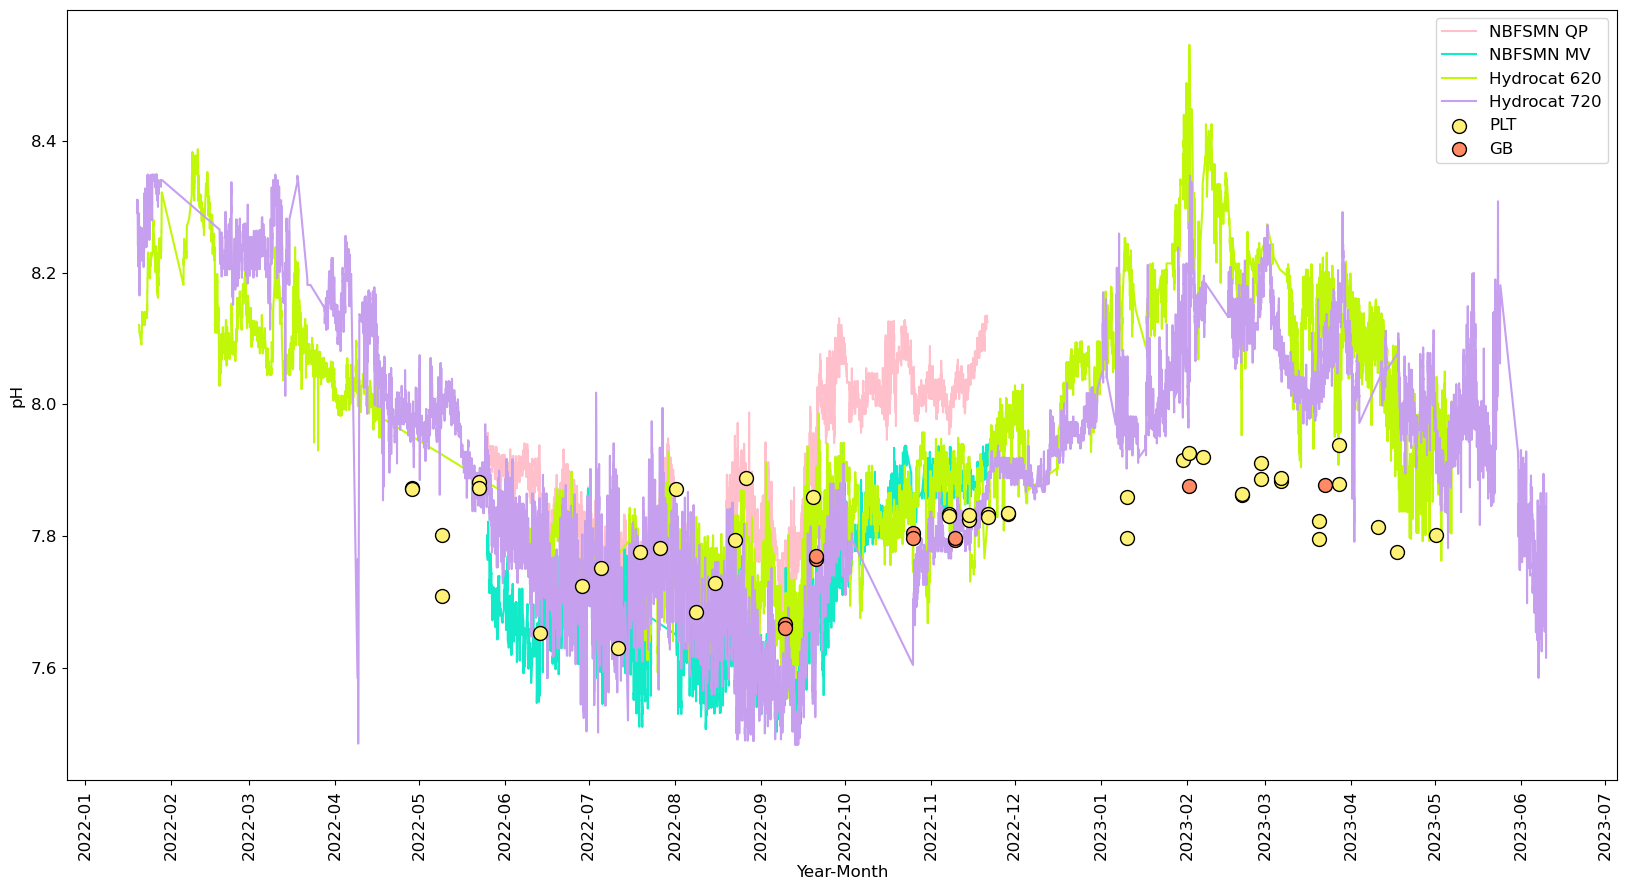

In [24]:
fig, ax = plt.subplots(figsize = [20,10])

ax.plot(QP['time'],QP['pH total'], 
        color = 'pink', label = 'NBFSMN QP')
ax.plot(MV['time'],MV['pH total'], 
           color = '#13EAC9', label = 'NBFSMN MV')
ax.plot(hydrocat620['time'], hydrocat620['pH total'], 
           color = '#C1F80A', label = 'Hydrocat 620')
ax.plot(hydrocat720['time'],hydrocat720['pH total'], 
           color = '#C79FEF', label = 'Hydrocat 720')
ax.scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax.scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#ff8a65', label = 'GB', zorder = 3)



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('pH', fontsize = 12)

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/prelim_pH_literallyeverything.png', bbox_inches='tight')


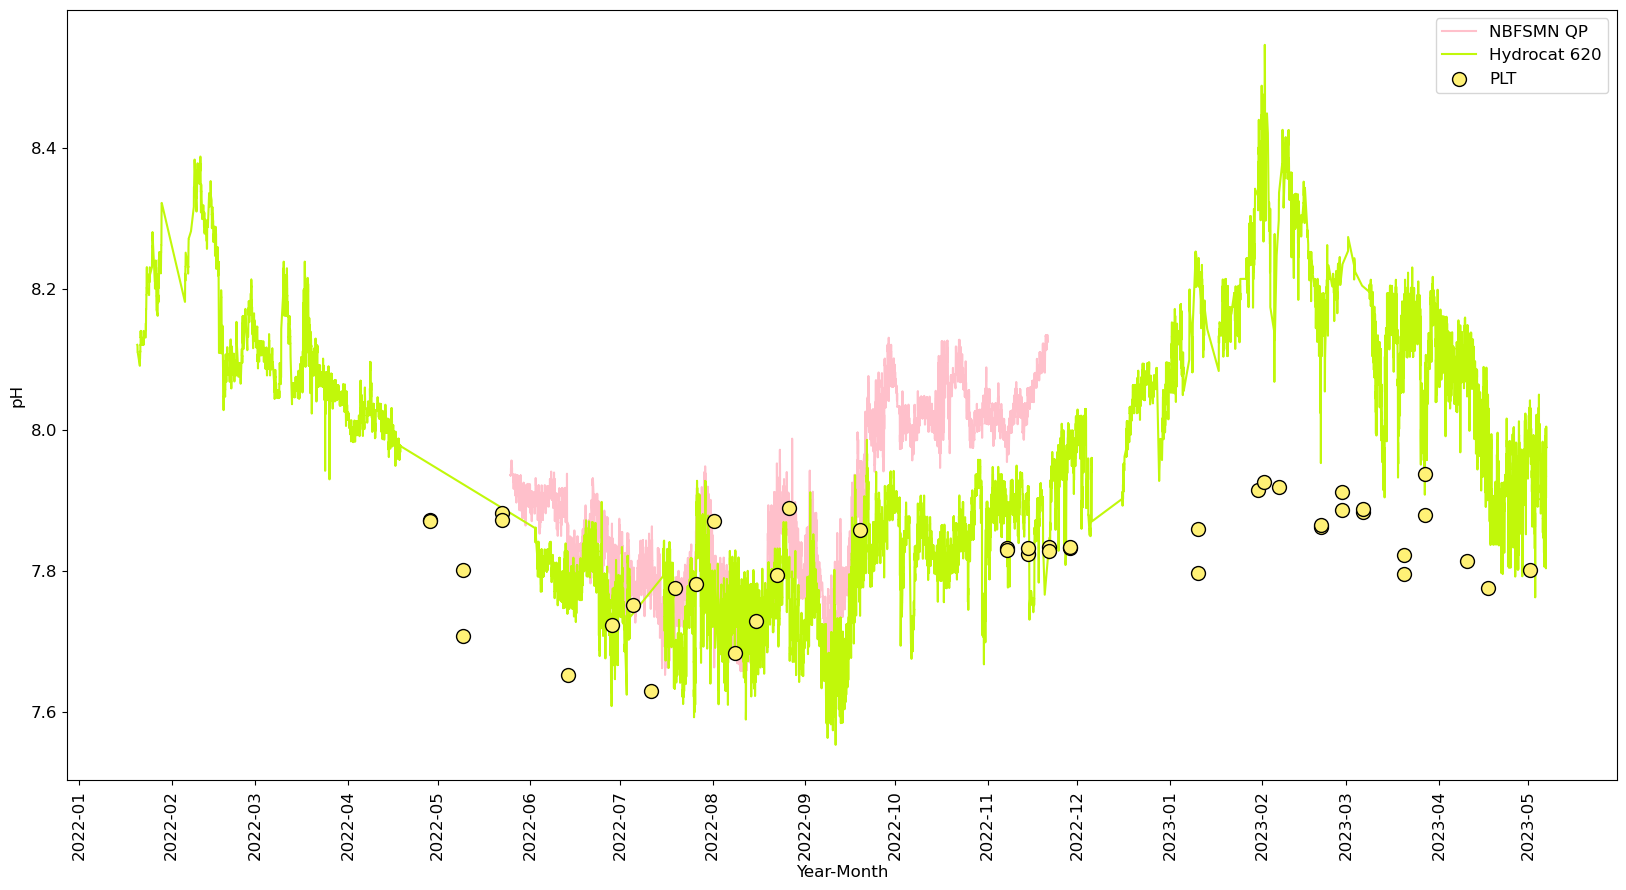

In [25]:
fig, ax = plt.subplots(figsize = [20,10])

ax.plot(QP['time'],QP['pH total'], 
        color = 'pink', label = 'NBFSMN QP')
# ax.plot(MV['time'],MV['pH total'], 
#            color = '#13EAC9', label = 'NBFSMN MV')
ax.plot(hydrocat620['time'], hydrocat620['pH total'], 
           color = '#C1F80A', label = 'Hydrocat 620')
# ax.plot(hydrocat720['time'],hydrocat720['pH total'], 
#            color = '#C79FEF', label = 'Hydrocat 720')
ax.scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
# ax.scatter(labGB['time'],labGB['pH'], 
#            marker = 'o', s = 100, edgecolors = 'k', facecolors = '#ff8a65', label = 'GB', zorder = 3)



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('pH', fontsize = 12)

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/QP_Buoy620_PLT.png', bbox_inches='tight')

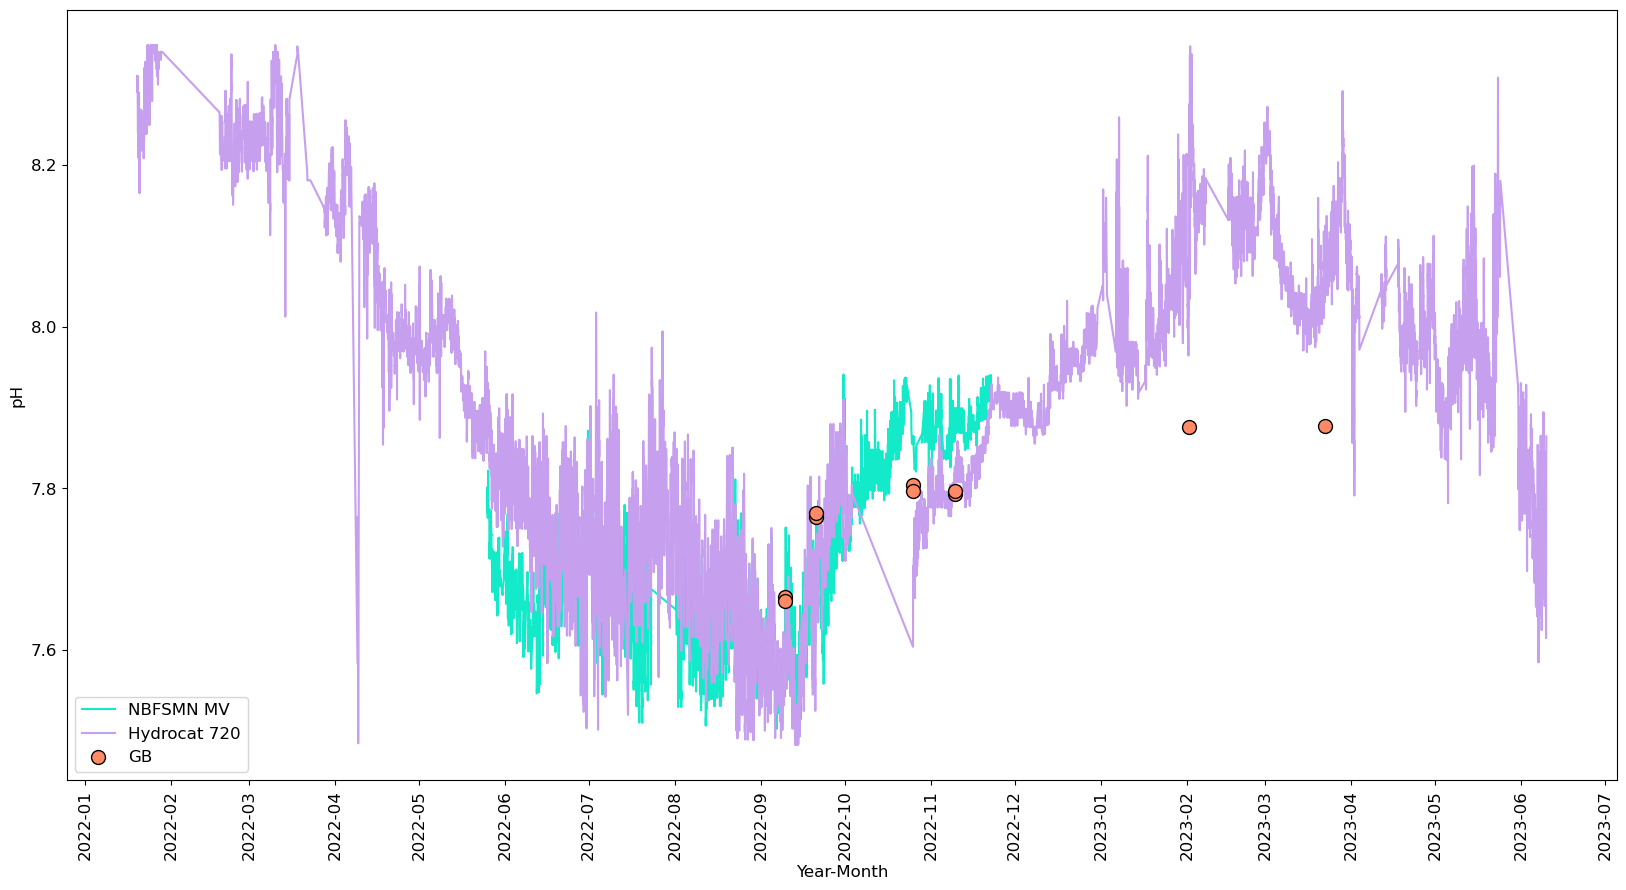

In [26]:
fig, ax = plt.subplots(figsize = [20,10])

# ax.plot(QP['time'],QP['pH total'], 
#         color = 'pink', label = 'NBFSMN QP')
ax.plot(MV['time'],MV['pH total'], 
           color = '#13EAC9', label = 'NBFSMN MV')
# ax.plot(hydrocat620['time'], hydrocat620['pH total'], 
#            color = '#C1F80A', label = 'Hydrocat 620')
ax.plot(hydrocat720['time'],hydrocat720['pH total'], 
           color = '#C79FEF', label = 'Hydrocat 720')
# ax.scatter(labPLT['time'],labPLT['pH'], 
#            marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax.scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#ff8a65', label = 'GB', zorder = 3)



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('pH', fontsize = 12)

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/MV_Buoy720_GB.png', bbox_inches='tight')

# Adjust sensor pH based on lab samples

- Fitting a 3rd order polynomial to the pH anomalies for both Hydrocats and QP, since those have noticeable error. MV appears fine when compared to the lab data.

- The 3rd order polynomial is a function of ordinal time

- The polynomial model provides "offset" or the amount by which the sensor exceeds the corresponding lab sample

- The offset is only applied during time periods with persistent bias (i.e. a single, stand-alone measurement outside of the instrument precision will not be affected) and when the modeled offset exceeds instrument precision of 0.1.

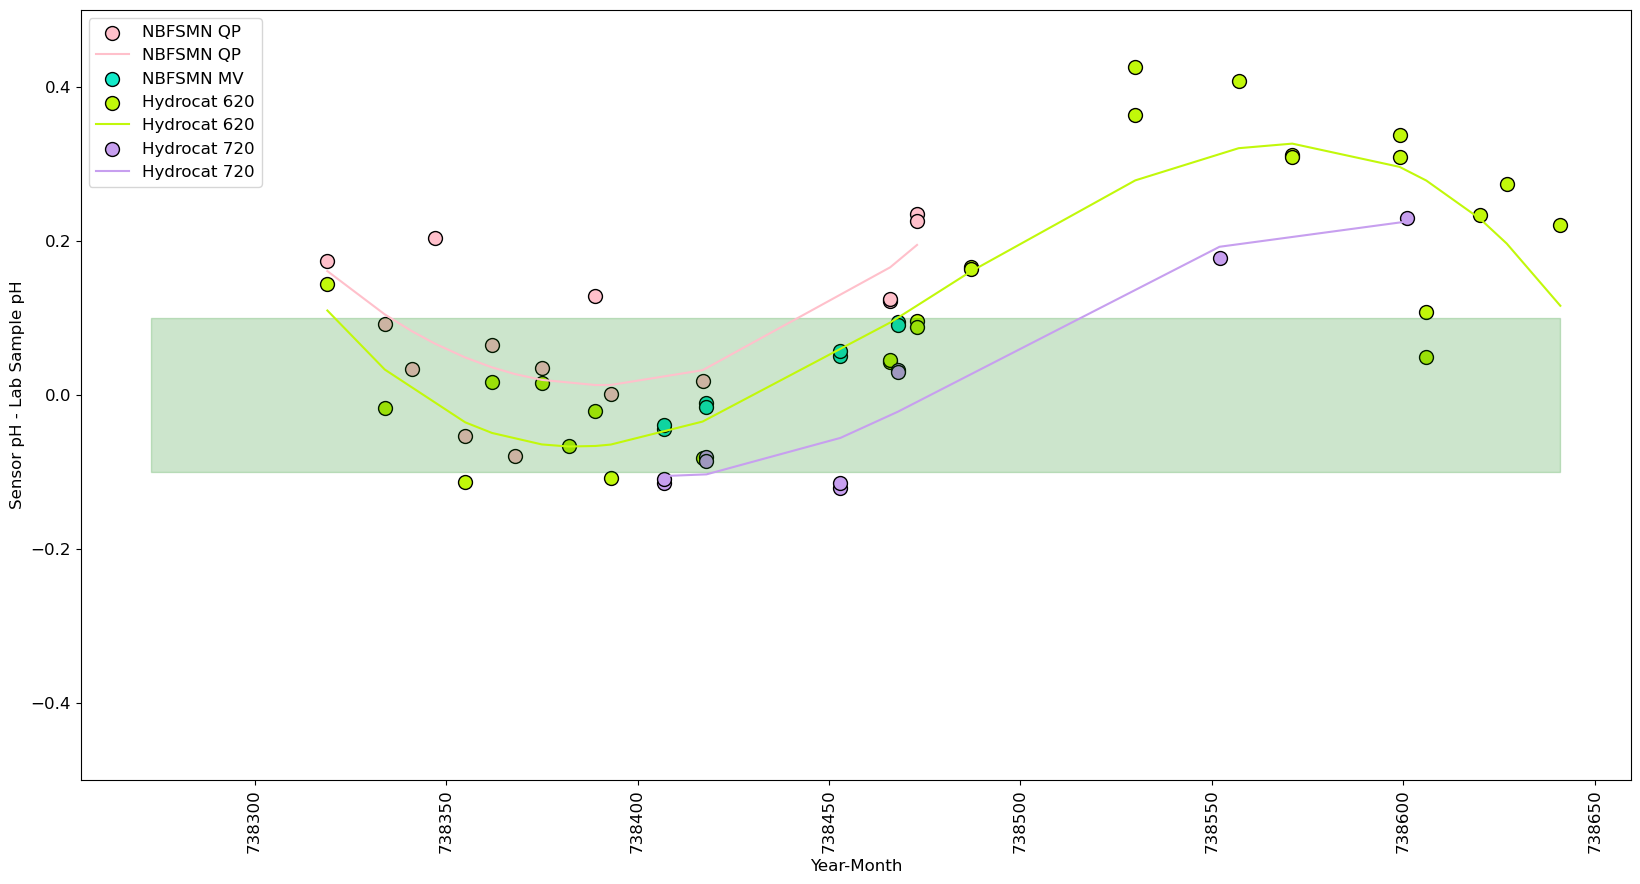

In [27]:
fig, ax = plt.subplots(figsize = [20,10])

PLT_QP_ = PLT_QP.dropna()
ax.scatter(PLT_QP_['ordinal_time_x'],PLT_QP_['pH total'] - PLT_QP_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
pxQP = np.poly1d(np.polyfit(PLT_QP_['ordinal_time_x'], PLT_QP_['pH total'] - PLT_QP_['pH'], 5))
ax.plot(PLT_QP_['ordinal_time_x'], pxQP(PLT_QP_['ordinal_time_x']), 
        color = 'pink', label = 'NBFSMN QP')

GB_MV_ = GB_MV.dropna()
ax.scatter(GB_MV_['ordinal_time_x'],GB_MV_['pH total'] - GB_MV_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#13EAC9', label = 'NBFSMN MV')

PLT_hydrocat620 = PLT_hydro620.dropna()
ax.scatter(PLT_hydrocat620['ordinal_time_x'],PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')
px620 = np.poly1d(np.polyfit(PLT_hydrocat620['ordinal_time_x'], PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 3))
ax.plot(PLT_hydrocat620['ordinal_time_x'], px620(PLT_hydrocat620['ordinal_time_x']), 
        color = '#C1F80A', label = 'Hydrocat 620')

GB_hydrocat720 = GB_hydro720.dropna()
ax.scatter(GB_hydrocat720['ordinal_time_x'],GB_hydrocat720['pH total'] - GB_hydrocat720['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#C79FEF', label = 'Hydrocat 720')
px720 = np.poly1d(np.polyfit(GB_hydrocat720['ordinal_time_x'], GB_hydrocat720['pH total'] - GB_hydrocat720['pH'], 3))
ax.plot(GB_hydrocat720['ordinal_time_x'], px720(GB_hydrocat720['ordinal_time_x']), 
        color = '#C79FEF', label = 'Hydrocat 720')

ax.fill_between(PLT_hydro620['ordinal_time_x'], -0.1, 0.1, color = 'g', alpha = 0.2)
# ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax.set_ylim([-0.5,0.5])
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/pH_adjustments_model.png', bbox_inches='tight')

In [28]:
hydrocat620['offset'] = np.zeros(len(hydrocat620['ordinal_time']))
hydrocat720['offset'] = np.zeros(len(hydrocat720['ordinal_time']))
QP['offset'] = np.zeros(len(QP['ordinal_time']))
for i in hydrocat620.index:
    t = hydrocat620['ordinal_time'][i]
    # if t > 738470 and t < 783650:
    if t > 738350:
        OFFSET = px620[0] + px620[1] * t + px620[2] * t**2 + px620[3] * t**3
        if np.abs(OFFSET) > 0.1:
            hydrocat620['offset'][i] = OFFSET
for j in hydrocat720.index:
    t = hydrocat720['ordinal_time'][j]
    # if t > 738470 and t < 783650:
    if t > 738350:
        OFFSET = px720[0] + px720[1] * t + px720[2] * t**2 + px720[3] * t**3
        if np.abs(OFFSET) > 0.1:
            hydrocat720['offset'][j] = OFFSET
for k in QP.index:
    t = QP['ordinal_time'][k]
    if t > 738300:
        OFFSET = pxQP[0] + pxQP[1] * t + pxQP[2] * t**2 + pxQP[3] * t**3 + pxQP[4] * t**4 + pxQP[5] * t**5
        if np.abs(OFFSET) >= 0.1:
            QP['offset'][k] = OFFSET

In [29]:
hydrocat620['adjusted_ph'] = np.zeros(len(hydrocat620['ordinal_time']))
hydrocat720['adjusted_ph'] = np.zeros(len(hydrocat720['ordinal_time']))
QP['adjusted_ph'] = np.zeros(len(QP['ordinal_time']))
for i in hydrocat620.index:
    hydrocat620['adjusted_ph'][i] = hydrocat620['pH total'][i] - hydrocat620['offset'][i]
for i in hydrocat720.index:
    hydrocat720['adjusted_ph'][i] = hydrocat720['pH total'][i] - hydrocat720['offset'][i]
for i in QP.index:
    QP['adjusted_ph'][i] = QP['pH total'][i] - QP['offset'][i]

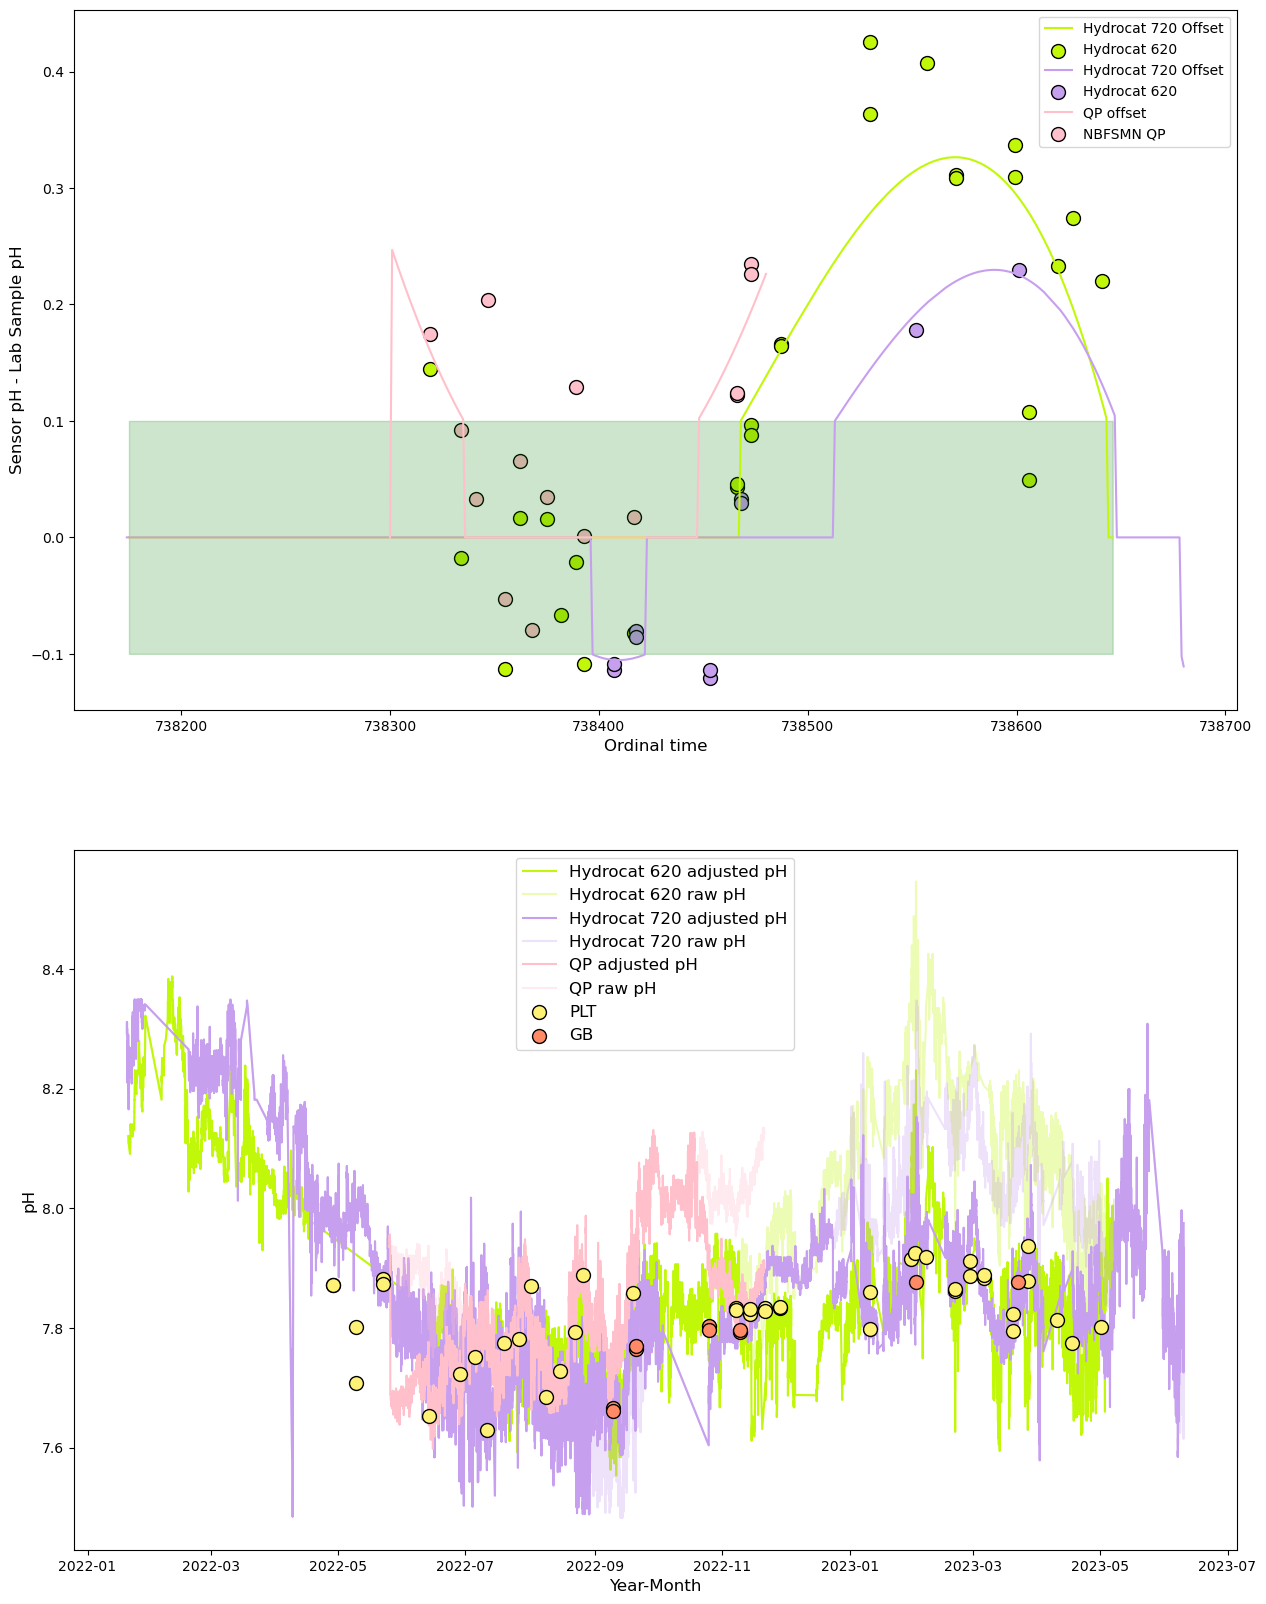

In [30]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,20])
ax[0].plot(hydrocat620['ordinal_time'], hydrocat620['offset'], color = '#C1F80A',  label = 'Hydrocat 720 Offset')
ax[0].scatter(PLT_hydrocat620['ordinal_time_x'],PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')
ax[0].plot(hydrocat720['ordinal_time'], hydrocat720['offset'], color = '#C79FEF',  label = 'Hydrocat 720 Offset')
ax[0].scatter(GB_hydrocat720['ordinal_time_x'],GB_hydrocat720['pH total'] - GB_hydrocat720['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C79FEF', label = 'Hydrocat 620')
ax[0].plot(QP['ordinal_time'], QP['offset'], color = 'pink', label = 'QP offset')
ax[0].scatter(PLT_QP_['ordinal_time_x'],PLT_QP_['pH total'] - PLT_QP_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
ax[0].set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax[0].set_xlabel('Ordinal time', fontsize = 12)
ax[0].legend()
ax[0].fill_between(hydrocat620['ordinal_time'], -0.1, 0.1, color = 'g', alpha = 0.2)

ax[1].plot(hydrocat620['time'], hydrocat620['adjusted_ph'], color = '#C1F80A', label = 'Hydrocat 620 adjusted pH')
ax[1].plot(hydrocat620['time'], hydrocat620['pH total'], alpha = 0.3, color = '#C1F80A', label = 'Hydrocat 620 raw pH')
ax[1].plot(hydrocat720['time'], hydrocat720['adjusted_ph'], color = '#C79FEF', label = 'Hydrocat 720 adjusted pH')
ax[1].plot(hydrocat720['time'], hydrocat720['pH total'], alpha = 0.3, color = '#C79FEF', label = 'Hydrocat 720 raw pH')
ax[1].plot(QP['time'], QP['adjusted_ph'], color = 'pink', label = 'QP adjusted pH')
ax[1].plot(QP['time'], QP['pH total'], alpha = 0.3, color = 'pink', label = 'QP raw pH')
ax[1].scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax[1].scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#ff8a65', label = 'GB', zorder = 3)
ax[1].set_ylabel('pH', fontsize = 12)
ax[1].set_xlabel('Year-Month', fontsize = 12)
ax[1].legend(fontsize = 12)

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/pH_adjustments.png', bbox_inches='tight')

In [31]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

In [43]:
#This is the Worksheet ID
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
d2g.upload(hydrocat620, spreadsheet_key, 'Hydrocat 620', credentials=credentials, row_names=False)
d2g.upload(hydrocat720, spreadsheet_key, 'Hydrocat 720', credentials=credentials, row_names=False)
d2g.upload(QP, spreadsheet_key, 'QP', credentials=credentials, row_names=False)

<Worksheet 'QP' id:502668473>

In [33]:
d2g.upload(MV, spreadsheet_key, 'MV', credentials=credentials, row_names=False)

<Worksheet 'MV' id:1972322447>

# Adjust sensor pH based on lab samples as a function of temperature

In [34]:
PLT_QP_.sort_values(by=['surface Temp'])

,Sample,DateTime_x,Location,depth,Salinity,DIC (umol/kg),TA (umol/kg),pH,time,ordinal_time_x,DateTime_y,ordinal_time_y,surface Temp,surface Salinity,surface DO Conc,pH total
20,NB143,2022-11-14 12:30:00,PLT,bottom,30.6500,1946.051574,2073.346779,7.823480,2022-11-14 12:30:00,738473.0,2022-11-14 12:30:00,738473.0,14.12,29.27,8.202,8.058236
21,NB217,2022-11-14 12:30:00,PLT,surface,30.6000,1948.081494,2078.402375,7.831965,2022-11-14 12:30:00,738473.0,2022-11-14 12:30:00,738473.0,14.12,29.27,8.202,8.058236
18,NB207,2022-11-07 12:30:00,PLT,bottom,30.5900,1946.235022,2076.649993,7.832549,2022-11-07 12:30:00,738466.0,2022-11-07 12:30:00,738466.0,16.16,29.22,8.101,7.954432
19,NB204,2022-11-07 12:30:00,PLT,surface,30.7500,1944.538153,2074.767505,7.830187,2022-11-07 12:30:00,738466.0,2022-11-07 12:30:00,738466.0,16.16,29.22,8.101,7.954432
6,PLT 6/13/22,2022-06-13 11:30:00,PLT,surface,30.0619,1963.399446,2031.932377,7.652208,2022-06-13 11:30:00,738319.0,2022-06-13 11:30:00,738319.0,21.00,30.43,7.661,7.826688
17,PLT 9/19/22,2022-09-19 11:30:00,PLT,surface,30.8339,1908.434611,2048.818736,7.858339,2022-09-19 11:30:00,738417.0,2022-09-19 11:30:00,738417.0,21.34,30.35,7.735,7.875940
7,PLT 6/28/22,2022-06-28 11:30:00,PLT,surface,30.3754,1964.076692,2056.710349,7.723379,2022-06-28 11:30:00,738334.0,2022-06-28 11:30:00,738334.0,21.60,30.46,7.306,7.815548
8,PLT 7/5/22,2022-07-05 11:30:00,PLT,surface,30.4300,1950.920644,2052.323802,7.751496,2022-07-05 11:30:00,738341.0,2022-07-05 11:30:00,738341.0,22.21,30.90,6.994,7.784802
9,PLT 7/11/22,2022-07-11 11:30:00,PLT,surface,30.7400,2007.470453,2072.169032,7.629225,2022-07-11 11:30:00,738347.0,2022-07-11 11:30:00,738347.0,22.86,30.51,7.372,7.833124
10,PLT 7/19/22,2022-07-19 11:30:00,PLT,surface,30.7300,1944.518665,2055.271484,7.775461,2022-07-19 11:30:00,738355.0,2022-07-19 11:30:00,738355.0,23.53,31.04,6.983,7.722307


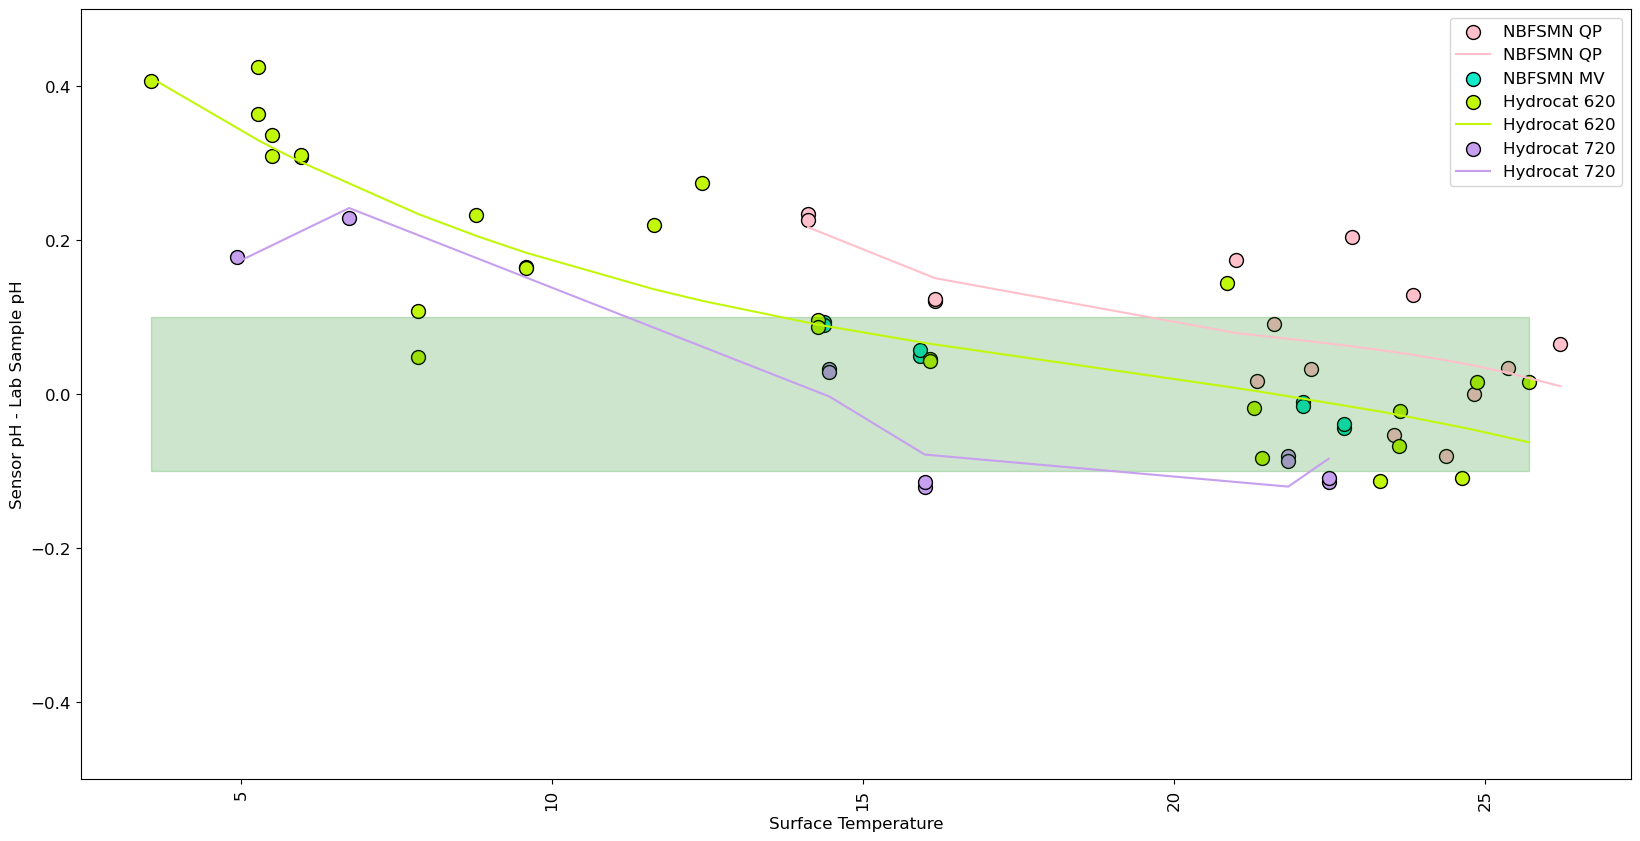

In [35]:
fig, ax = plt.subplots(figsize = [20,10])

PLT_QP_ = PLT_QP.dropna()
PLT_QP_ = PLT_QP_.sort_values(by=['surface Temp'])
ax.scatter(PLT_QP_['surface Temp'],PLT_QP_['pH total'] - PLT_QP_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
pxQP = np.poly1d(np.polyfit(PLT_QP_['surface Temp'], PLT_QP_['pH total'] - PLT_QP_['pH'], 3))
ax.plot(PLT_QP_['surface Temp'], pxQP(PLT_QP_['surface Temp']), 
        color = 'pink', label = 'NBFSMN QP')

GB_MV_ = GB_MV.dropna()
GB_MV_ = GB_MV_.sort_values(by=['surface Temp'])
ax.scatter(GB_MV_['surface Temp'],GB_MV_['pH total'] - GB_MV_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#13EAC9', label = 'NBFSMN MV')

PLT_hydrocat620 = PLT_hydro620.dropna()
PLT_hydrocat620 = PLT_hydrocat620.sort_values(by=['hydrocatTemperature'])
ax.scatter(PLT_hydrocat620['hydrocatTemperature'],PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')
px620 = np.poly1d(np.polyfit(PLT_hydrocat620['hydrocatTemperature'], PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 3))
ax.plot(PLT_hydrocat620['hydrocatTemperature'], px620(PLT_hydrocat620['hydrocatTemperature']), 
        color = '#C1F80A', label = 'Hydrocat 620')

GB_hydrocat720 = GB_hydro720.dropna()
GB_hydrocat720 = GB_hydrocat720.sort_values(by=['hydrocatTemperature'])
ax.scatter(GB_hydrocat720['hydrocatTemperature'],GB_hydrocat720['pH total'] - GB_hydrocat720['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#C79FEF', label = 'Hydrocat 720')
px720 = np.poly1d(np.polyfit(GB_hydrocat720['hydrocatTemperature'], GB_hydrocat720['pH total'] - GB_hydrocat720['pH'], 3))
ax.plot(GB_hydrocat720['hydrocatTemperature'], px720(GB_hydrocat720['hydrocatTemperature']), 
        color = '#C79FEF', label = 'Hydrocat 720')

ax.fill_between(PLT_hydrocat620['hydrocatTemperature'], -0.1, 0.1, color = 'g', alpha = 0.2)
# ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Surface Temperature', fontsize = 12)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax.set_ylim([-0.5,0.5])
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/pH_adjustments_model.png', bbox_inches='tight')

In [36]:
hydrocat620['offset temp'] = np.zeros(len(hydrocat620['ordinal_time']))
hydrocat720['offset temp'] = np.zeros(len(hydrocat720['ordinal_time']))
QP['offset temp'] = np.zeros(len(QP['ordinal_time']))
for i in hydrocat620.index:
    t = hydrocat620['hydrocatTemperature'][i]
    # if t > 738470 and t < 783650:
    if t < 30:
        OFFSET = px620[0] + px620[1] * t + px620[2] * t**2 + px620[3] * t**3
        if np.abs(OFFSET) > 0.1:
            hydrocat620['offset temp'][i] = OFFSET
for j in hydrocat720.index:
    t = hydrocat720['hydrocatTemperature'][j]
    # if t > 738470 and t < 783650:
    # if t < 24:
    if t < 15:
        OFFSET = px720[0] + px720[1] * t + px720[2] * t**2 + px720[3] * t**3
        if np.abs(OFFSET) > 0.1:
            hydrocat720['offset temp'][j] = OFFSET
for k in QP.index:
    t = QP['surface Temp'][k]
    # if t < 25:
    OFFSET = pxQP[0] + pxQP[1] * t + pxQP[2] * t**2 + pxQP[3] * t**3 # + pxQP[4] * t**4 + pxQP[5] * t**5
    if np.abs(OFFSET) >= 0.1:
        QP['offset temp'][k] = OFFSET

In [37]:
QP.where(QP['offset temp'] != 0).dropna()

,DateTime,time,ordinal_time,surface Temp,surface Salinity,surface DO Conc,pH total,offset,adjusted_ph,offset temp
0,2022-05-25 08:00:00,2022-05-25 08:00:00,738300.0,16.35,30.70,8.208,7.935983,0.00000,7.935983,0.146351
1,2022-05-25 08:15:00,2022-05-25 08:15:00,738300.0,16.44,30.71,8.223,7.935824,0.00000,7.935824,0.144214
2,2022-05-25 08:30:00,2022-05-25 08:30:00,738300.0,16.35,30.73,8.230,7.936022,0.00000,7.936022,0.146351
3,2022-05-25 08:45:00,2022-05-25 08:45:00,738300.0,16.58,30.67,8.227,7.935504,0.00000,7.935504,0.140985
4,2022-05-25 09:00:00,2022-05-25 09:00:00,738300.0,16.56,30.69,8.227,7.935568,0.00000,7.935568,0.141439
...,...,...,...,...,...,...,...,...,...,...
15737,2022-11-21 04:00:00,2022-11-21 04:00:00,738480.0,10.44,29.40,8.739,8.125085,0.22626,7.898825,0.434910
15738,2022-11-21 04:15:00,2022-11-21 04:15:00,738480.0,10.46,29.43,8.615,8.125095,0.22626,7.898835,0.433300
15739,2022-11-21 04:30:00,2022-11-21 04:30:00,738480.0,10.48,29.34,8.732,8.124922,0.22626,7.898662,0.431695
15740,2022-11-21 04:45:00,2022-11-21 04:45:00,738480.0,10.51,29.43,8.642,8.125005,0.22626,7.898745,0.429298


In [38]:
hydrocat620['adjusted_ph temp'] = np.zeros(len(hydrocat620['ordinal_time']))
hydrocat720['adjusted_ph temp'] = np.zeros(len(hydrocat720['ordinal_time']))
QP['adjusted_ph temp'] = np.zeros(len(QP['ordinal_time']))
for i in hydrocat620.index:
    hydrocat620['adjusted_ph temp'][i] = hydrocat620['pH total'][i] - hydrocat620['offset temp'][i]
for i in hydrocat720.index:
    hydrocat720['adjusted_ph temp'][i] = hydrocat720['pH total'][i] - hydrocat720['offset temp'][i]
for i in QP.index:
    QP['adjusted_ph temp'][i] = QP['pH total'][i] - QP['offset temp'][i]

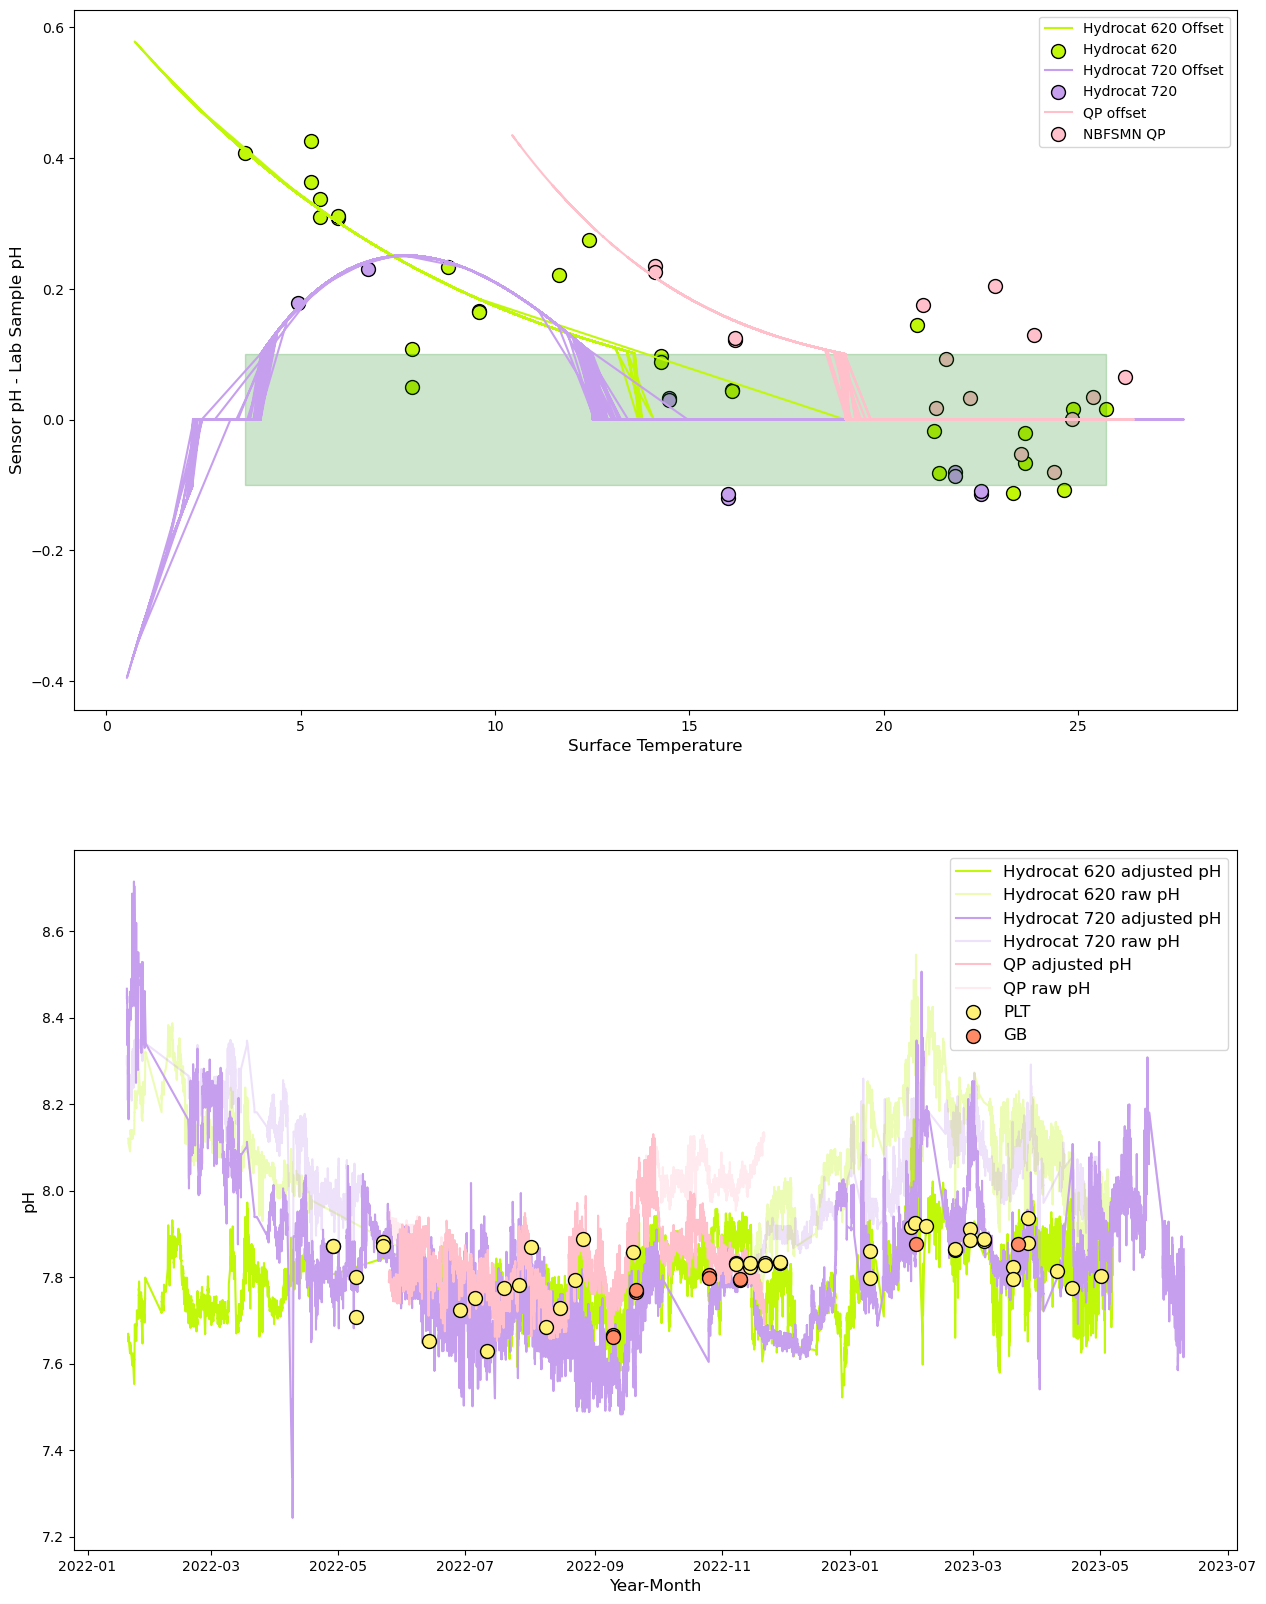

In [39]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,20])
ax[0].plot(hydrocat620['hydrocatTemperature'], hydrocat620['offset temp'], color = '#C1F80A',  label = 'Hydrocat 620 Offset')
ax[0].scatter(PLT_hydrocat620['hydrocatTemperature'],PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')
ax[0].plot(hydrocat720['hydrocatTemperature'], hydrocat720['offset temp'], color = '#C79FEF',  label = 'Hydrocat 720 Offset')
ax[0].scatter(GB_hydrocat720['hydrocatTemperature'],GB_hydrocat720['pH total'] - GB_hydrocat720['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C79FEF', label = 'Hydrocat 720')
ax[0].plot(QP['surface Temp'], QP['offset temp'], color = 'pink', label = 'QP offset')
ax[0].scatter(PLT_QP_['surface Temp'],PLT_QP_['pH total'] - PLT_QP_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
ax[0].set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax[0].set_xlabel('Surface Temperature', fontsize = 12)
ax[0].legend()
ax[0].fill_between(PLT_hydrocat620['hydrocatTemperature'], -0.1, 0.1, color = 'g', alpha = 0.2)

ax[1].plot(hydrocat620['time'], hydrocat620['adjusted_ph temp'], color = '#C1F80A', label = 'Hydrocat 620 adjusted pH')
ax[1].plot(hydrocat620['time'], hydrocat620['pH total'], alpha = 0.3, color = '#C1F80A', label = 'Hydrocat 620 raw pH')
ax[1].plot(hydrocat720['time'], hydrocat720['adjusted_ph temp'], color = '#C79FEF', label = 'Hydrocat 720 adjusted pH')
ax[1].plot(hydrocat720['time'], hydrocat720['pH total'], alpha = 0.3, color = '#C79FEF', label = 'Hydrocat 720 raw pH')
ax[1].plot(QP['time'], QP['adjusted_ph temp'], color = 'pink', label = 'QP adjusted pH')
ax[1].plot(QP['time'], QP['pH total'], alpha = 0.3, color = 'pink', label = 'QP raw pH')
ax[1].scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax[1].scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#ff8a65', label = 'GB', zorder = 3)
ax[1].set_ylabel('pH', fontsize = 12)
ax[1].set_xlabel('Year-Month', fontsize = 12)
ax[1].legend(fontsize = 12)



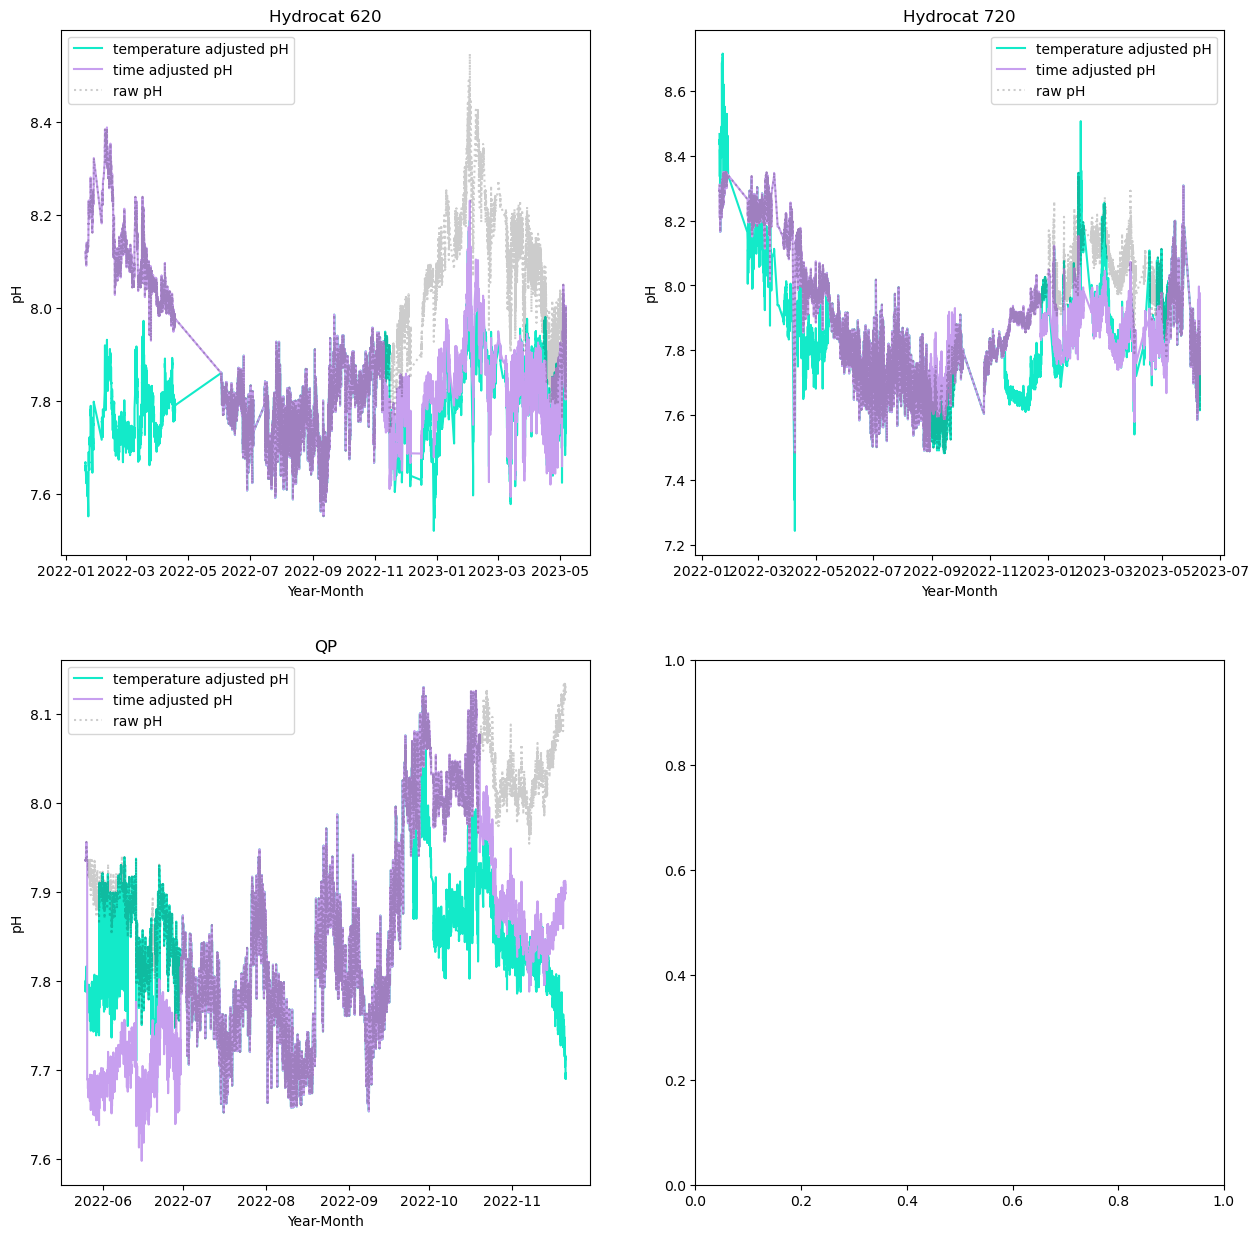

In [40]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [15,15])
axarr = axarr.flatten()
axarr[0].plot(hydrocat620['time'], hydrocat620['adjusted_ph temp'], color = '#13EAC9', label = 'temperature adjusted pH')
axarr[0].plot(hydrocat620['time'], hydrocat620['adjusted_ph'], color = '#C79FEF', label = 'time adjusted pH')
axarr[0].plot(hydrocat620['time'], hydrocat620['pH total'], color = 'k', ls = 'dotted', alpha = 0.2, label = 'raw pH')
axarr[0].set_xlabel('Year-Month')
axarr[0].set_ylabel('pH')
axarr[0].set_title('Hydrocat 620')
axarr[0].legend()

axarr[1].plot(hydrocat720['time'], hydrocat720['adjusted_ph temp'], color = '#13EAC9', label = 'temperature adjusted pH')
axarr[1].plot(hydrocat720['time'], hydrocat720['adjusted_ph'], color = '#C79FEF', label = 'time adjusted pH')
axarr[1].plot(hydrocat720['time'], hydrocat720['pH total'], color = 'k', ls = 'dotted', alpha = 0.2, label = 'raw pH')
axarr[1].set_xlabel('Year-Month')
axarr[1].set_ylabel('pH')
axarr[1].set_title('Hydrocat 720')
axarr[1].legend()

axarr[2].plot(QP['time'], QP['adjusted_ph temp'], color = '#13EAC9', label = 'temperature adjusted pH')
axarr[2].plot(QP['time'], QP['adjusted_ph'], color = '#C79FEF', label = 'time adjusted pH')
axarr[2].plot(QP['time'], QP['pH total'], color = 'k', ls = 'dotted', alpha = 0.2, label = 'raw pH')
axarr[2].set_xlabel('Year-Month')
axarr[2].set_ylabel('pH')
axarr[2].set_title('QP')
axarr[2].legend()

Text(0.5, 1.0, 'Temperature Adjusted pH')

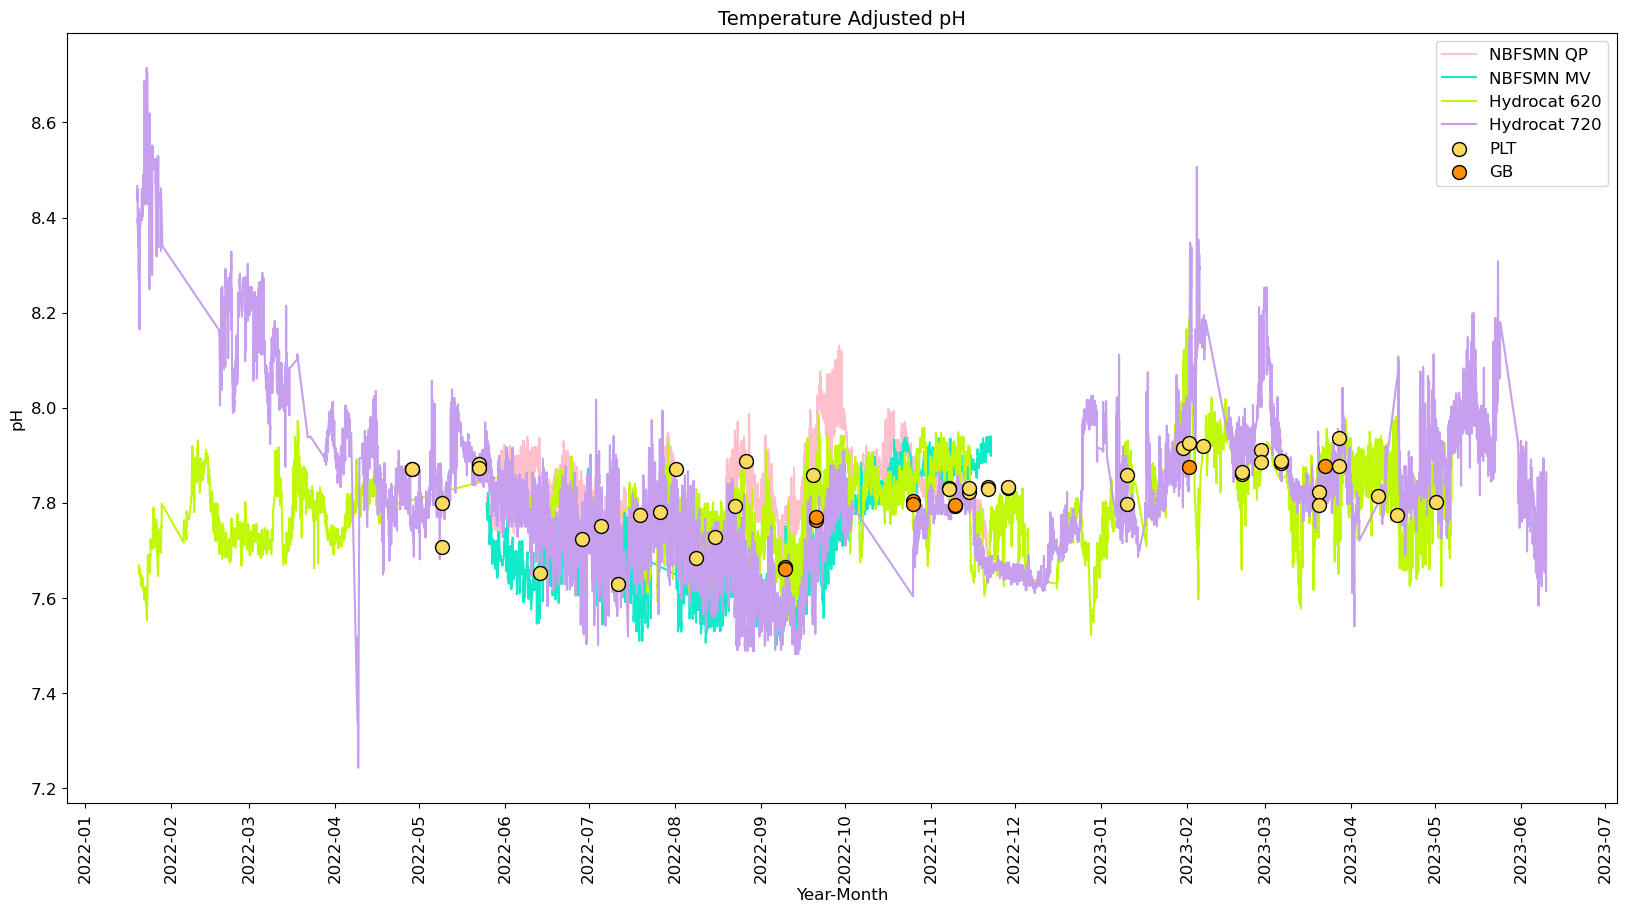

In [41]:
fig, ax = plt.subplots(figsize = [20,10])

ax.plot(QP['time'],QP['adjusted_ph temp'], 
        color = 'pink', label = 'NBFSMN QP')
ax.plot(MV['time'],MV['pH total'], 
           color = '#13EAC9', label = 'NBFSMN MV')
ax.plot(hydrocat620['time'], hydrocat620['adjusted_ph temp'], 
           color = '#C1F80A', label = 'Hydrocat 620')
ax.plot(hydrocat720['time'],hydrocat720['adjusted_ph temp'], 
           color = '#C79FEF', label = 'Hydrocat 720')
ax.scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#FADA5E', label = 'PLT', zorder = 3)
ax.scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#FF8F00', label = 'GB', zorder = 3)



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('pH', fontsize = 12)
ax.set_title('Temperature Adjusted pH', fontsize = 14)

# fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/prelim_pH_literallyeverything.png', bbox_inches='tight')fig, ax = plt.subplots(figsize = [20,10])


Text(0.5, 1.0, 'Time Adjusted pH')

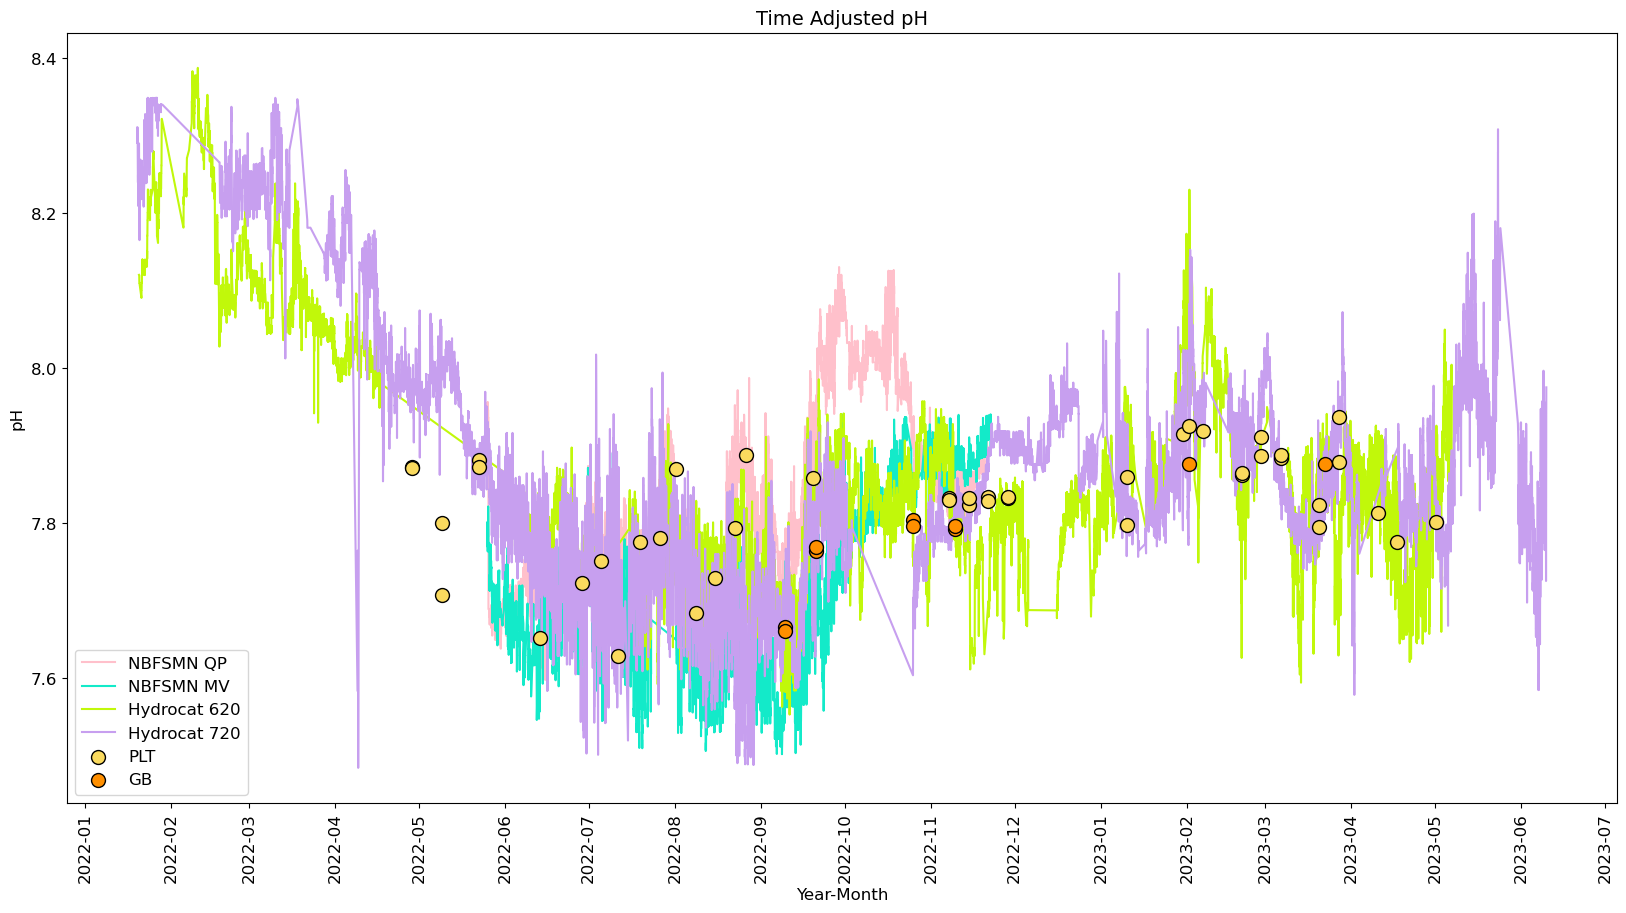

In [42]:
fig, ax = plt.subplots(figsize = [20,10])

ax.plot(QP['time'],QP['adjusted_ph'], 
        color = 'pink', label = 'NBFSMN QP')
ax.plot(MV['time'],MV['pH total'], 
           color = '#13EAC9', label = 'NBFSMN MV')
ax.plot(hydrocat620['time'], hydrocat620['adjusted_ph'], 
           color = '#C1F80A', label = 'Hydrocat 620')
ax.plot(hydrocat720['time'],hydrocat720['adjusted_ph'], 
           color = '#C79FEF', label = 'Hydrocat 720')
ax.scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#FADA5E', label = 'PLT', zorder = 3)
ax.scatter(labGB['time'],labGB['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#FF8F00', label = 'GB', zorder = 3)



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('pH', fontsize = 12)

ax.set_title('Time Adjusted pH', fontsize = 14)